# Project: Stock Indices prediction

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#prediction">Time Series Prediction and Assessment</a></li>
<li><a href="#conclusion">Conclusion</a></li>
</ul

<a id='intro'></a>
## Introduction

In this project we would like to identify which Stock Index is the most predictable out of 10 major indices defined using Machine Learning models. 

The purpose is to increase profitability in making investment decisions via reducing risks associated with the investments. We have decided to use 4 metrics to evaluate the performance of 4 models (ARIMA, XGBoost, LightGBM and Random Forest), all to be described below.
The idea is to come-up with the most predictable Stock index and the best performing model stepwise to increase efficiency and reduce computing powers. Thus, during Exploratory Data Analysis we will make a decision to focus on 3 indices out of 10 in the scope and afterwards use MAE, RMSE, WMAPE and R-squared metrics to define the most predictable Stock index.

In order to solve this problem, we have decided to use closing weekly prices of major indices from publicly available resources.

*Note on Use of metrics*: In evaluating model performance for predicting stock market indices, metrics such as Mean Absolute Error (MAE), Root Mean Square Error (RMSE), Weighted Mean Absolute Percentage Error (WMAPE), and R-squared are essential due to their ability to capture different aspects of prediction accuracy and error magnitude. MAE provides a clear average error, while RMSE emphasizes larger errors, which is crucial in financial contexts where significant deviations can have substantial impacts. WMAPE offers a normalized view of error relative to actual values, making it particularly useful in variable-scale financial data. R-squared indicates how well the model explains the variability in the target variable, reflecting its predictive power. Together, these metrics highlight the performance of models.

### Dataset Description

The following data has been used:
- weekly closing prices for the period from 01-2000 until 02-2025 (we believe that >24 years of weekly data should suffice for the defined analysis)
- data available from the widely-know source on stock prices Investing.com (Stock Market Index - Major World Indices Live)  accessible via https://www.investing.com/indices/major-indices
- 10 major indices were selected: S&P 500, Dow Jones, DAX, Euro Stoxx 50, FTSE 100, FTSE China A50, MSCI World, NASDAQ, US 30 and US Small Cap

In [1]:
# !pip install pandas numpy statsmodels scikit-learn xgboost lightgbm

In [2]:
# Setting up import statements for the required packages used in this report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Loading data
df=pd.read_csv('data/Historical_Data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11352 entries, 0 to 11351
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      11352 non-null  object
 1   Price     11352 non-null  object
 2   Open      11352 non-null  object
 3   High      11352 non-null  object
 4   Low       11352 non-null  object
 5   Vol.      6391 non-null   object
 6   Change %  11352 non-null  object
 7   Index     11352 non-null  object
dtypes: object(8)
memory usage: 709.6+ KB


In [5]:
df.describe()

Date      Price       Open      High       Low   Vol. Change %  \
count       11352      11352      11352     11352     11352   6391    11352   
unique       1313      11168      11130     11154     11175   3107     1486   
top     2/23/2025  10,447.90  24,519.20  1,103.70  1,191.50  1.29B    0.10%   
freq           10          3          2         3         3     34       47   

        Index  
count   11352  
unique     10  
top       DAX  
freq     1313

In [6]:
df.head()

Date      Price       Open       High        Low     Vol. Change %  \
0  2/23/2025  22,561.92  22,512.15  22,832.82  22,233.72  417.95M    1.23%   
1  2/16/2025  22,287.56  22,589.91  22,935.06  22,226.34  327.15M   -1.00%   
2   2/9/2025  22,513.42  21,830.93  22,624.57  21,785.02  348.64M    3.33%   
3   2/2/2025  21,787.00  21,301.53  21,945.31  21,252.71  349.99M    0.25%   
4  1/26/2025  21,732.05  21,201.99  21,800.52  21,081.61  368.61M    1.58%   

  Index  
0   DAX  
1   DAX  
2   DAX  
3   DAX  
4   DAX

In [7]:
# Analysis on the existence of null values
df.isnull().sum()

Date           0
Price          0
Open           0
High           0
Low            0
Vol.        4961
Change %       0
Index          0
dtype: int64

<a id='wrangling'></a>
## Data Wrangling

In [8]:
# dropping unnecessarily columns, keeping only the relevant ones
df1 = df.drop(["Open", "High", "Low", "Vol."], axis=1)

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11352 entries, 0 to 11351
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      11352 non-null  object
 1   Price     11352 non-null  object
 2   Change %  11352 non-null  object
 3   Index     11352 non-null  object
dtypes: object(4)
memory usage: 354.9+ KB


In [10]:
# converting dtypes
df1['Date'] = pd.to_datetime(df1['Date'], format='%m/%d/%Y')

df1['Price'] = df1['Price'].str.replace(',', '', regex=False).astype(float)

df1['Change %'] = df1['Change %'].str.replace('%', '').astype(float) / 100

In [11]:
# checking dtypes
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11352 entries, 0 to 11351
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      11352 non-null  datetime64[ns]
 1   Price     11352 non-null  float64       
 2   Change %  11352 non-null  float64       
 3   Index     11352 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 354.9+ KB


In [12]:
df1.head()

Date     Price  Change % Index
0 2025-02-23  22561.92    0.0123   DAX
1 2025-02-16  22287.56   -0.0100   DAX
2 2025-02-09  22513.42    0.0333   DAX
3 2025-02-02  21787.00    0.0025   DAX
4 2025-01-26  21732.05    0.0158   DAX

In [13]:
# dropping Change % for some part of EDA
df2 = df1.drop(["Change %"], axis=1)

<a id='eda'></a>
## Exploratory Data Analysis

In this section we will perform EDA to understand data better, define and re-iterate data wrangling activities (if needed), and define 3 stocks out of 10 for further steps in this project based on the various factors, such as: diversity of a stock index versus others (it has been decided to avoid choosing stock indices with similar parameters as a way to increase variability of indices), correlation to others, volatility (too volatile stock indices will be eliminated as a way to reduce overall portfolio risks) and the relevance in the current context of the analysis.

In [14]:
df2.describe()

Date         Price
count                          11352  11352.000000
mean   2013-11-12 18:26:00.253699840   8138.889920
min              2000-01-02 00:00:00    344.930000
25%              2008-07-27 00:00:00   2138.500000
50%              2014-04-09 12:00:00   5782.035000
75%              2019-09-15 00:00:00  11239.165000
max              2025-02-23 00:00:00  44953.500000
std                              NaN   8129.110189

#### Creating a line chart per stock index over the period

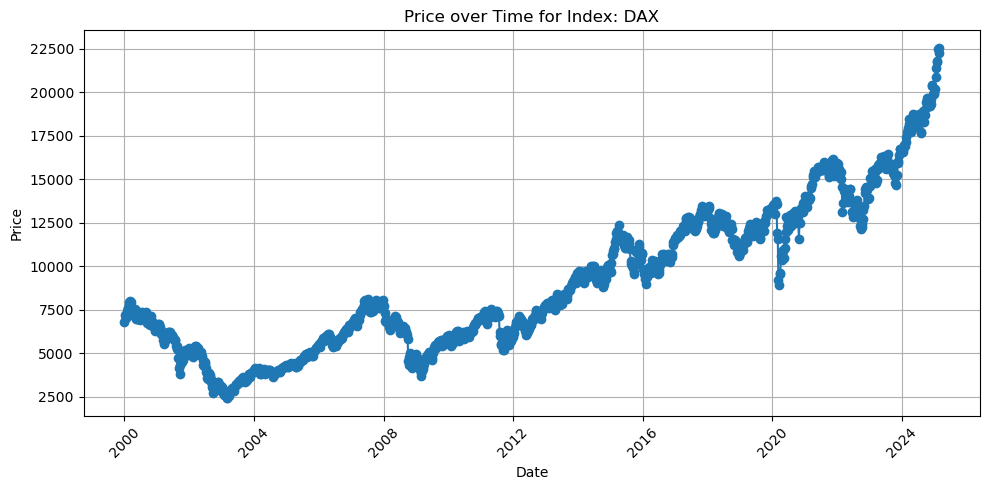

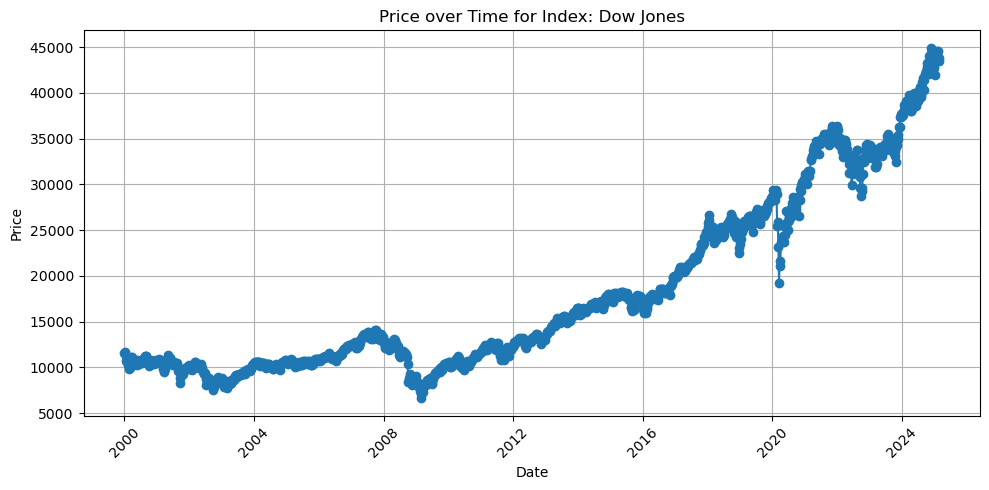

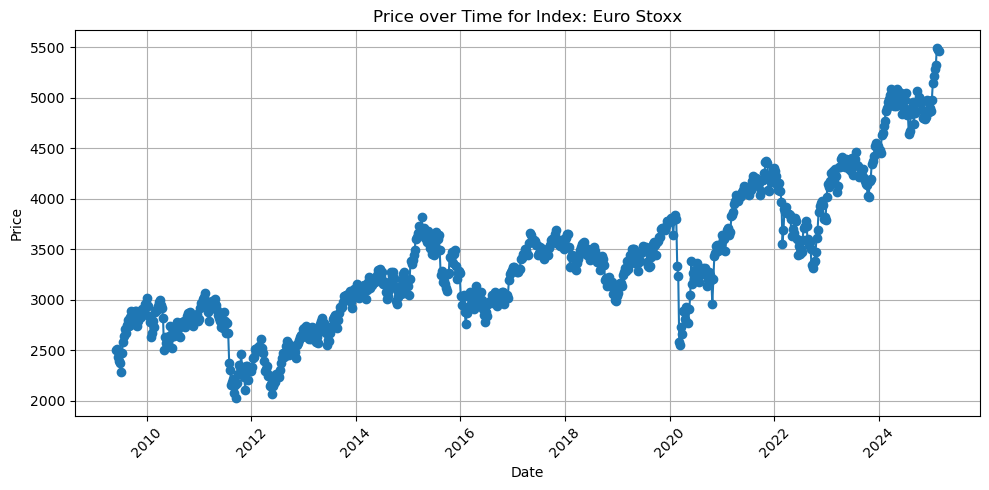

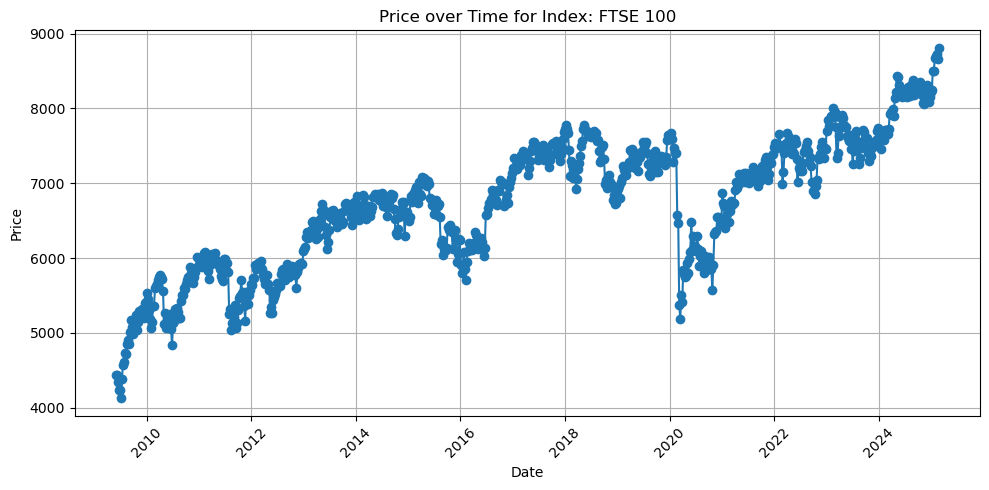

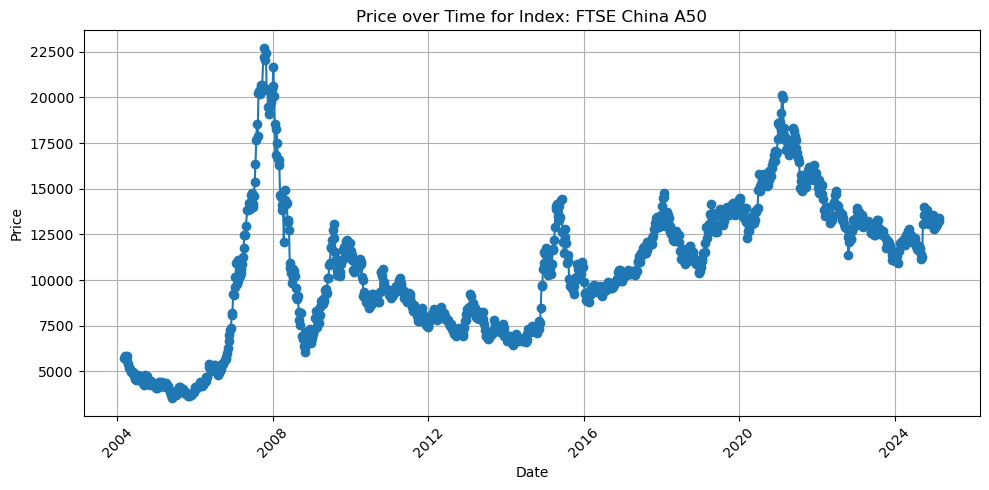

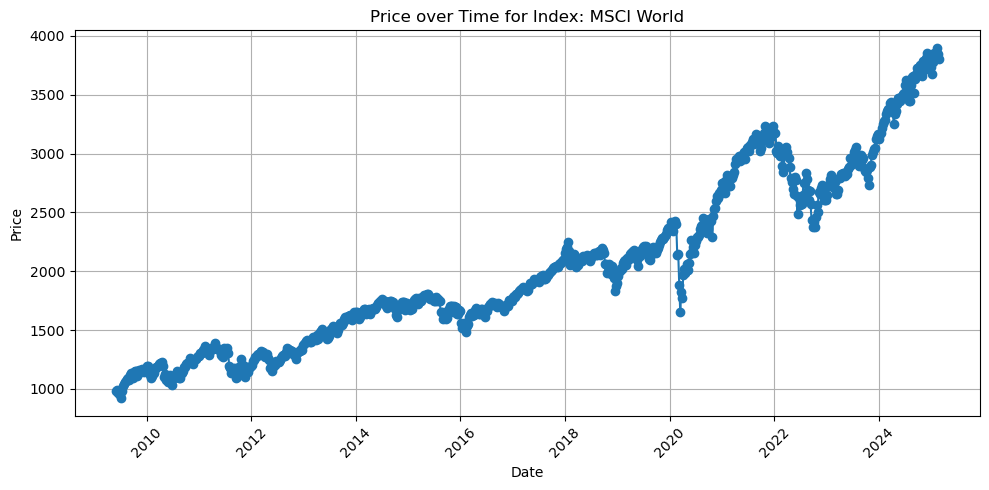

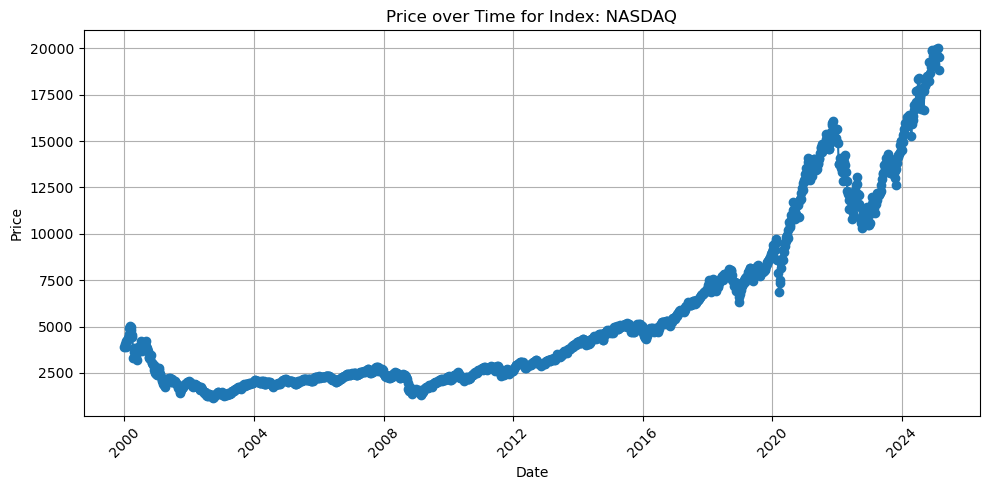

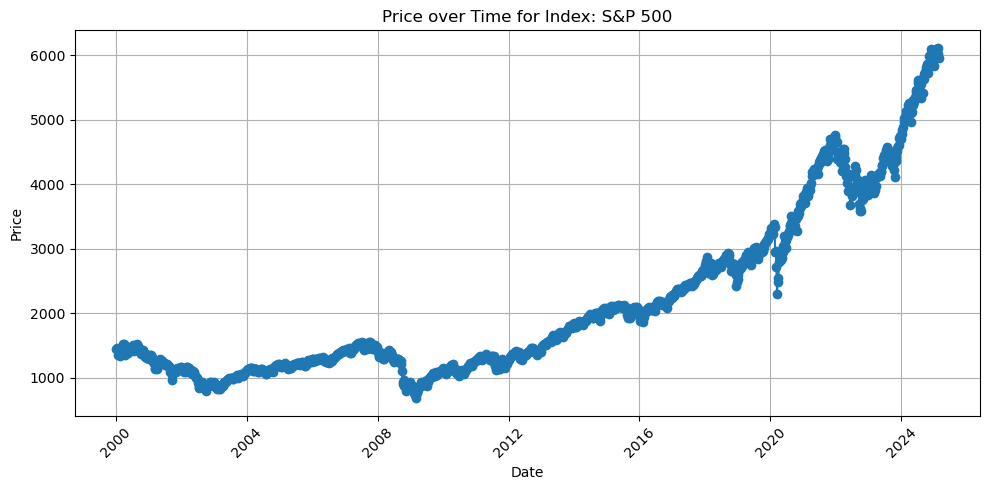

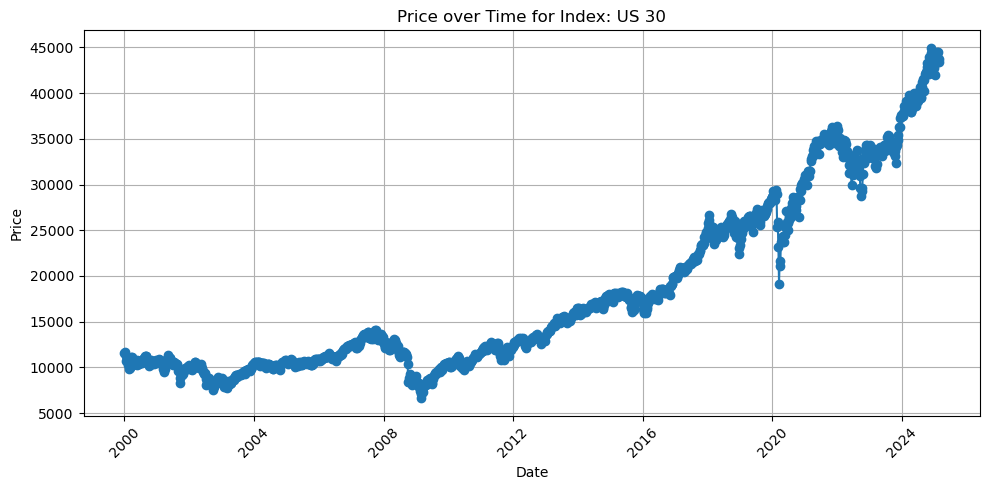

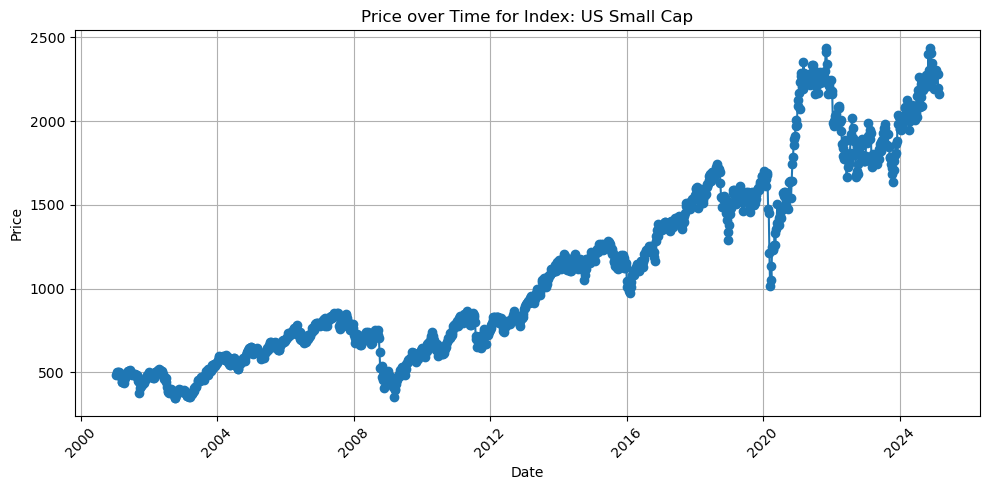

In [15]:
# Geting unique indices
unique_indices = df2['Index'].unique()

# Create a line chart for each unique index
for index in unique_indices:
    index_data = df2[df2['Index'] == index]
    
    plt.figure(figsize=(10, 5))
    plt.plot(index_data['Date'], index_data['Price'], marker='o', linestyle='-')
    plt.title(f'Price over Time for Index: {index}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()  

#### Visualizing all indices in one chart

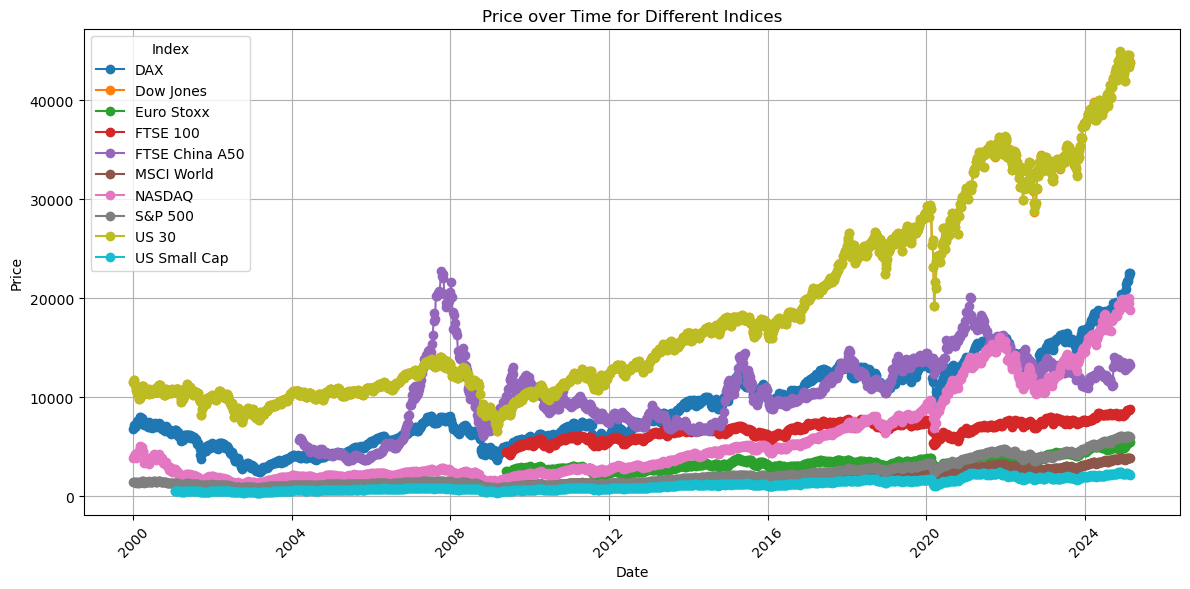

In [16]:
# Create a line chart for all indices on the same plot
plt.figure(figsize=(12, 6))

for index in unique_indices:
    index_data = df2[df2['Index'] == index]
    plt.plot(index_data['Date'], index_data['Price'], marker='o', linestyle='-', label=index)

plt.title('Price over Time for Different Indices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='Index')
plt.tight_layout()
plt.show()

**OBSERVATION** There are some World-wide ups and downs in the data affecting various stock indices at the same time, e.g. drop in 2020, after 2008 etc. indicating on the existence of trends affecting all markets.

#### Now we will try to look into each Index separately (whether there are any visible trends per year during the selected period)

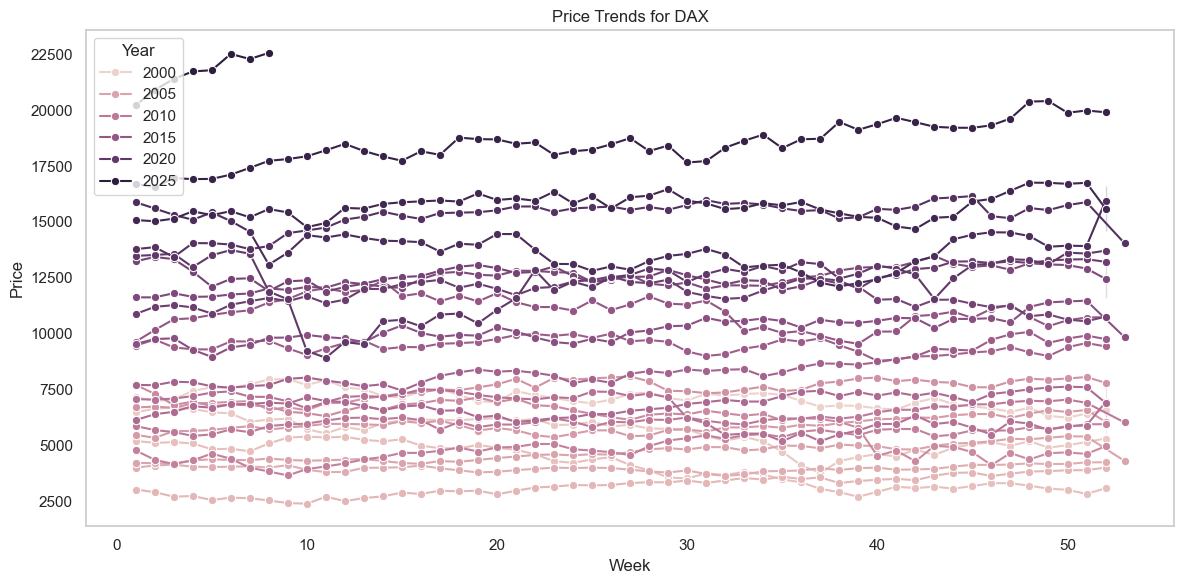

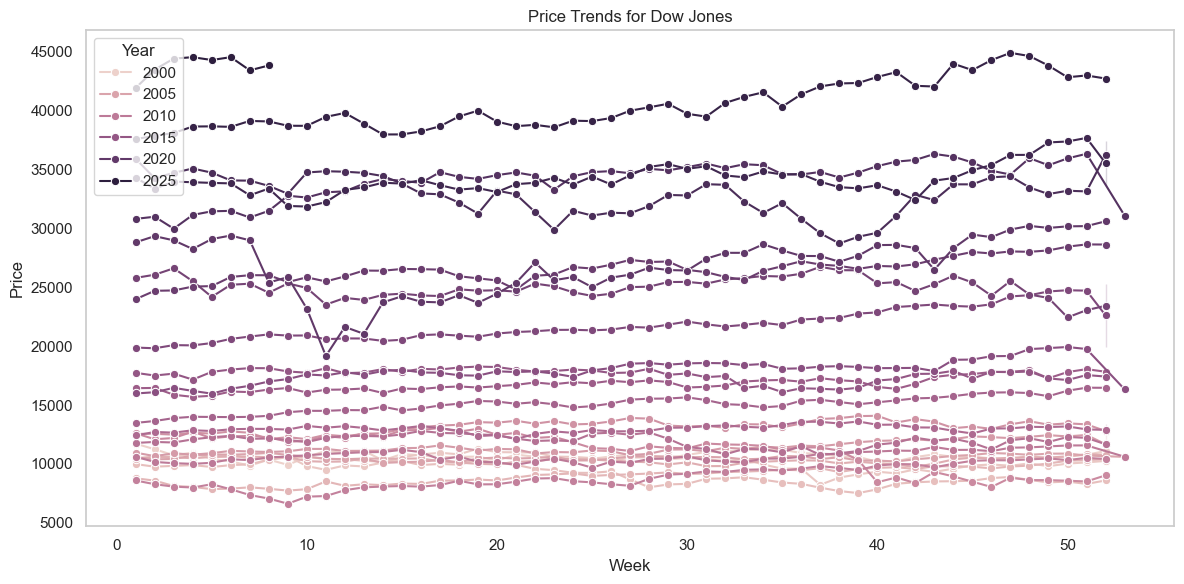

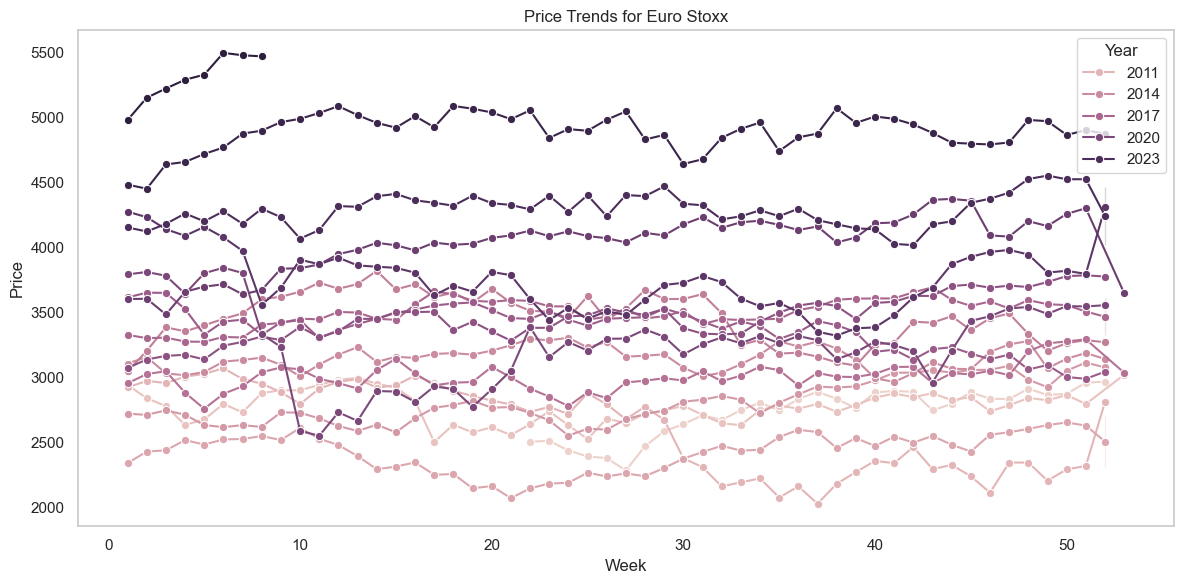

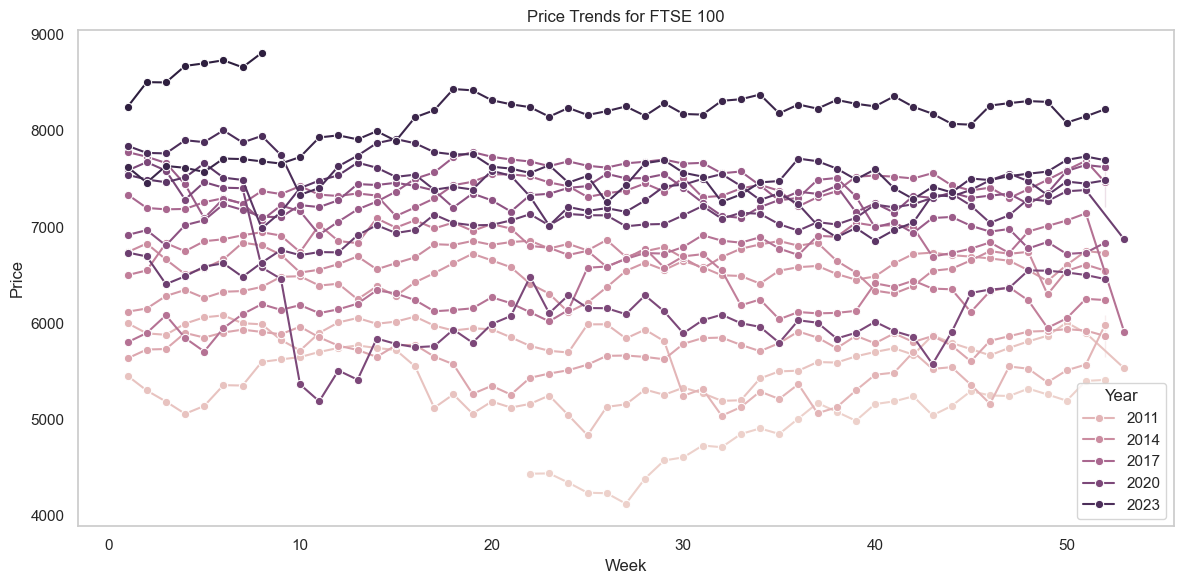

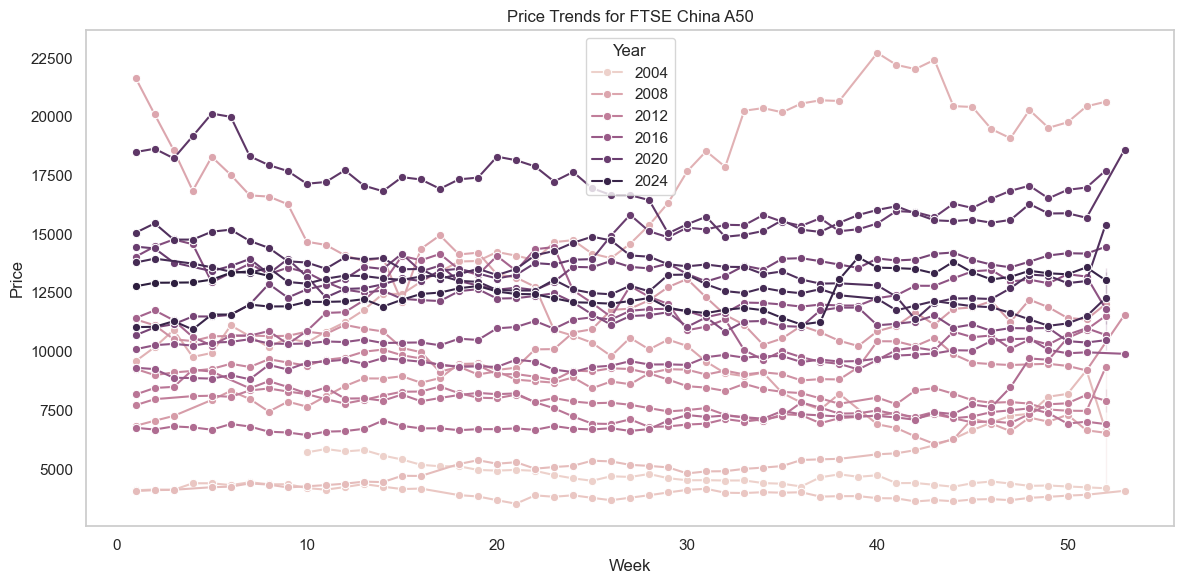

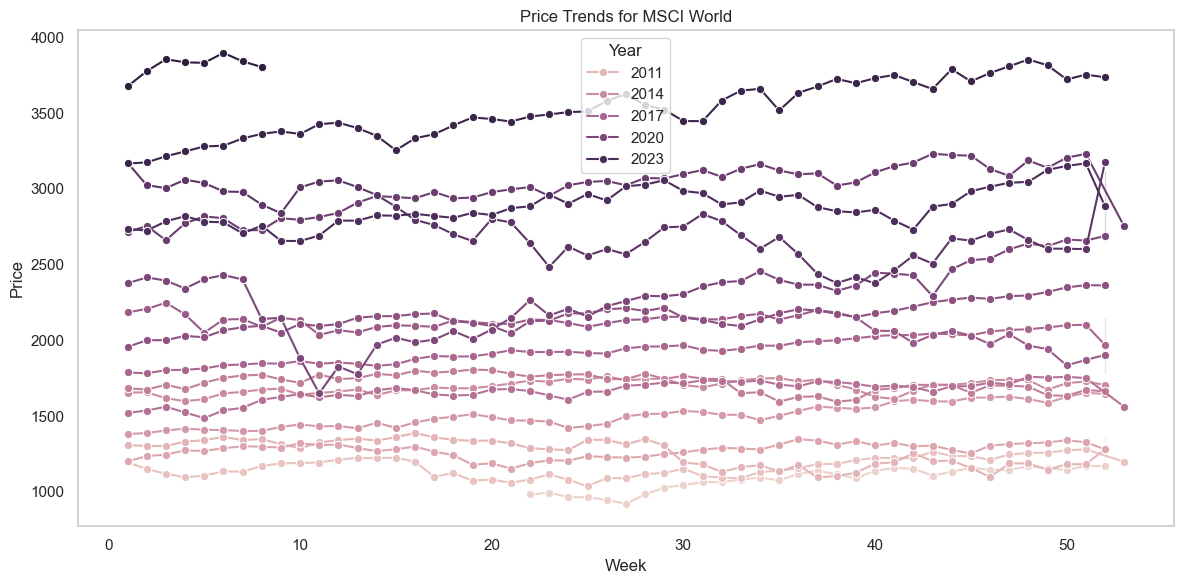

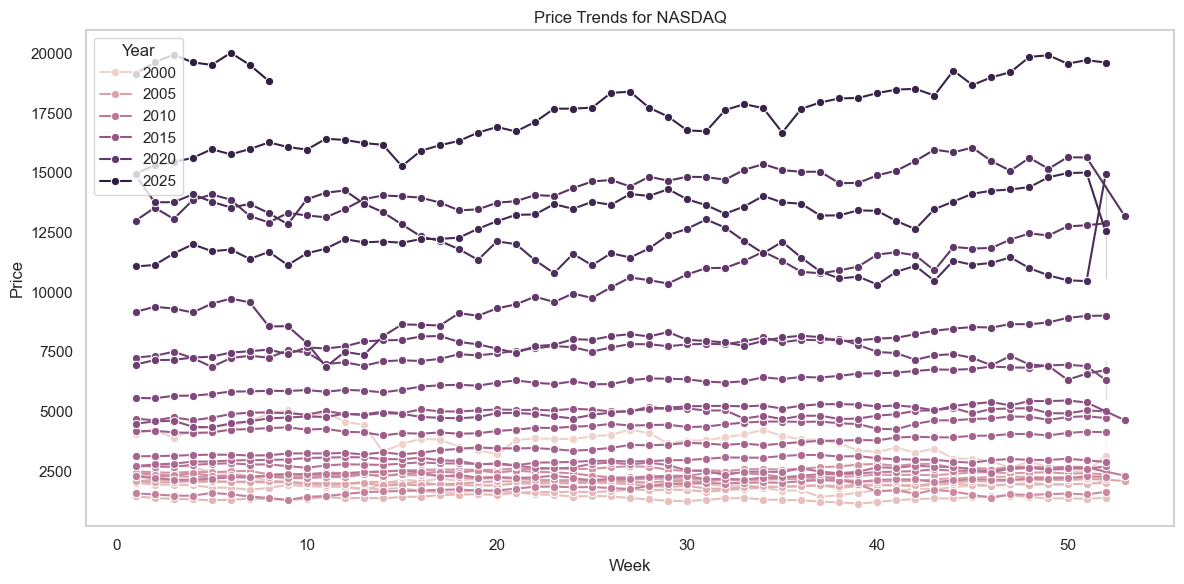

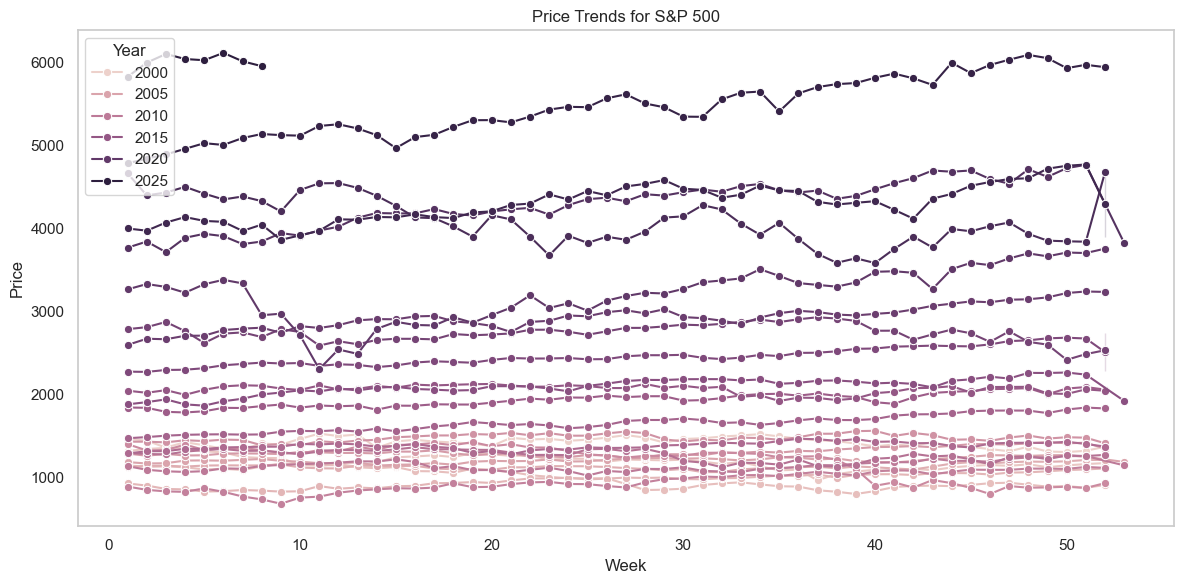

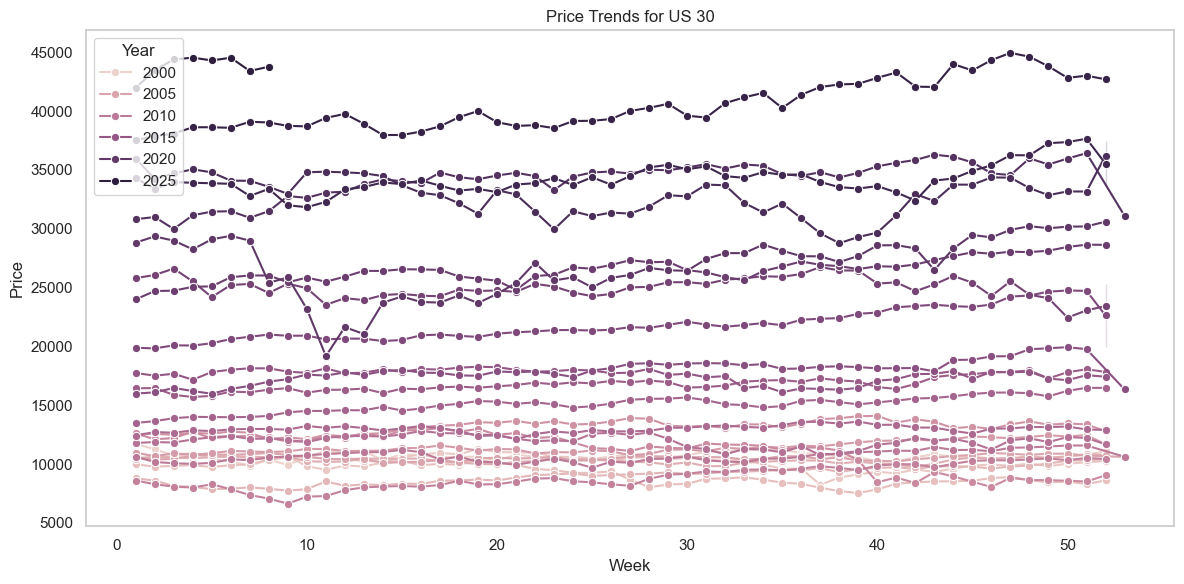

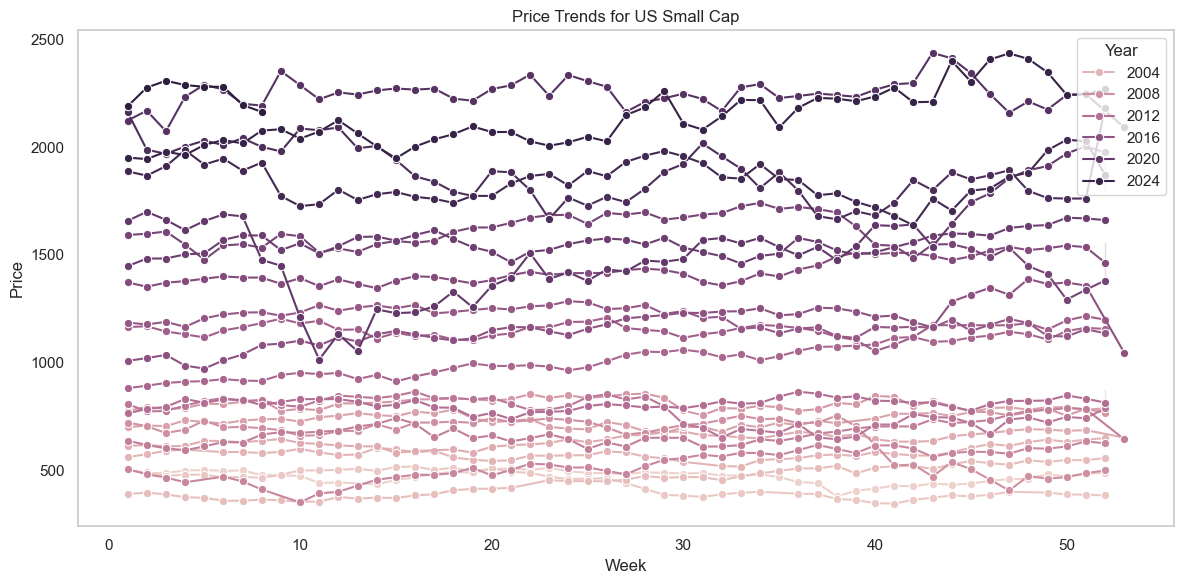

In [17]:
# Extract week number and year from the Date
df2['Week'] = df2['Date'].dt.isocalendar().week
df2['Year'] = df2['Date'].dt.year

# Create a list of unique indices
unique_indices = df2['Index'].unique()

# Set the style for seaborn
sns.set(style="whitegrid")

# Create line charts for each Index
for index in unique_indices:
    # Filter the DataFrame for the current Index
    df_index = df2[df2['Index'] == index]

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Use seaborn's lineplot to plot the data
    sns.lineplot(data=df_index, x='Week', y='Price', hue='Year', marker='o')

    # Set the title and labels
    plt.title(f'Price Trends for {index}')
    plt.xlabel('Week')
    plt.ylabel('Price')
    plt.legend(title='Year')
    plt.grid()

    # Show the plot
    plt.tight_layout()
    plt.show()

**OBSERVATION** There are seems like some patterns around week 8-10 for stock to decrease as well as observed visible tendency of prices to go up over time every year (partially due to inflation).

#### Let's observe box plots for all the years combined separately for each Stock Index

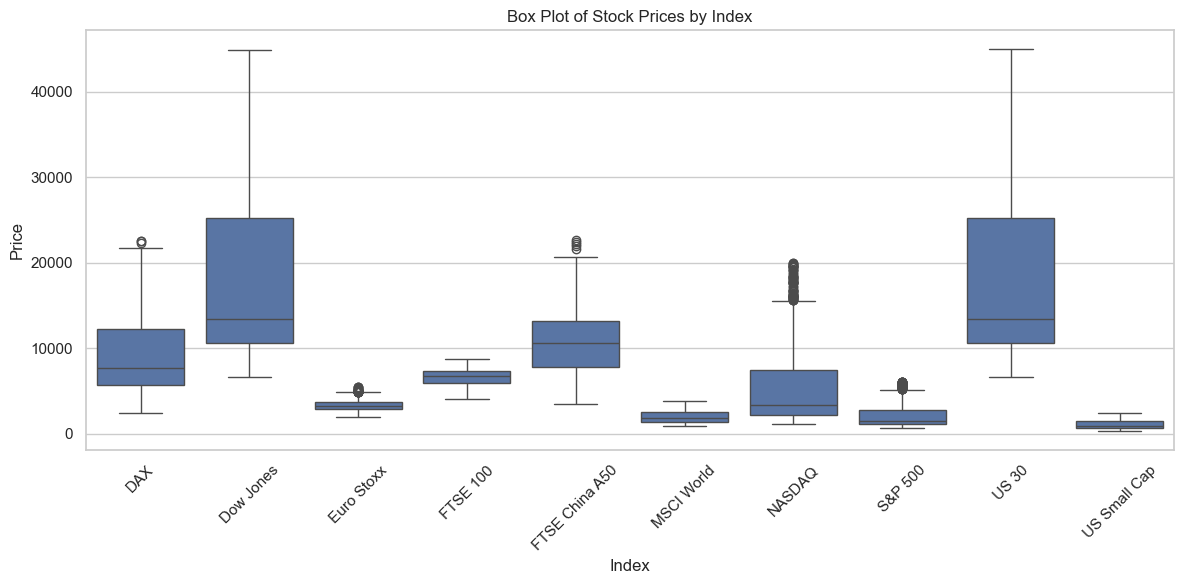

In [18]:
# Setting the style for the plots
sns.set(style="whitegrid")

# Create a box plot for each index
plt.figure(figsize=(12, 6))
sns.boxplot(x='Index', y='Price', data=df2)

plt.title('Box Plot of Stock Prices by Index')
plt.xlabel('Index')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Box plots separately per each 5 year period, as 2000s could not be compared to the recent periods

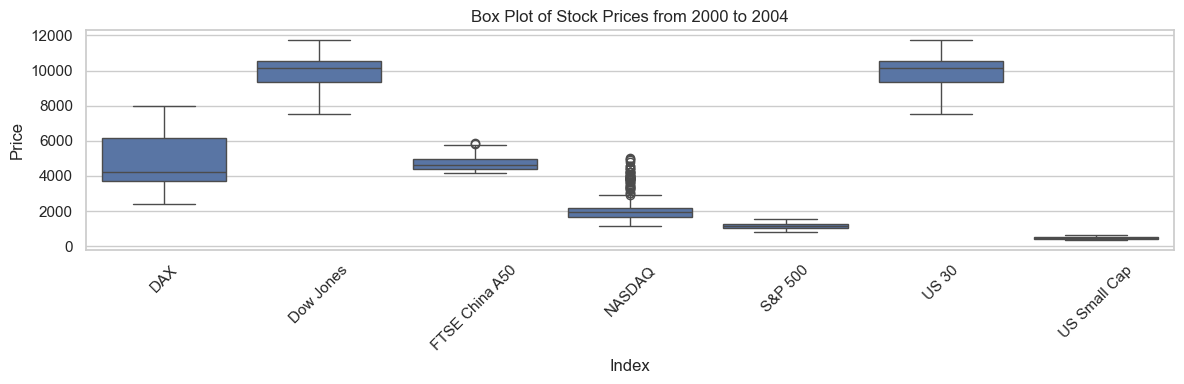

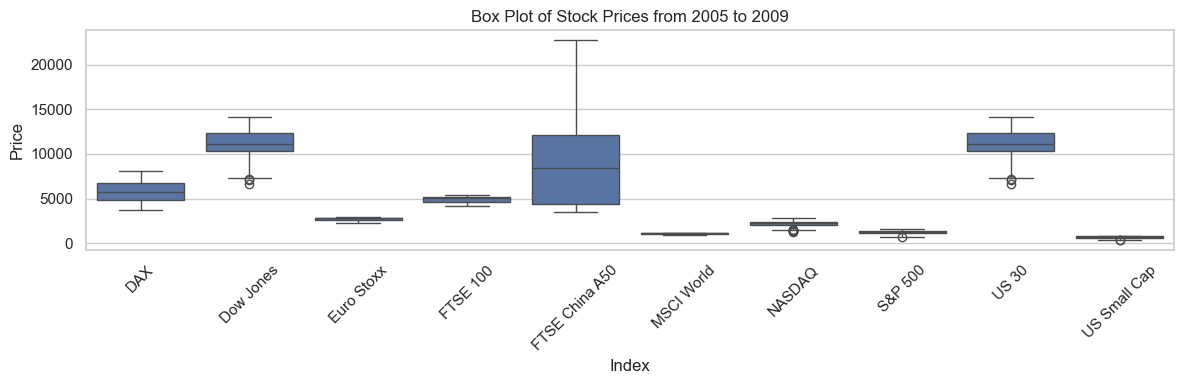

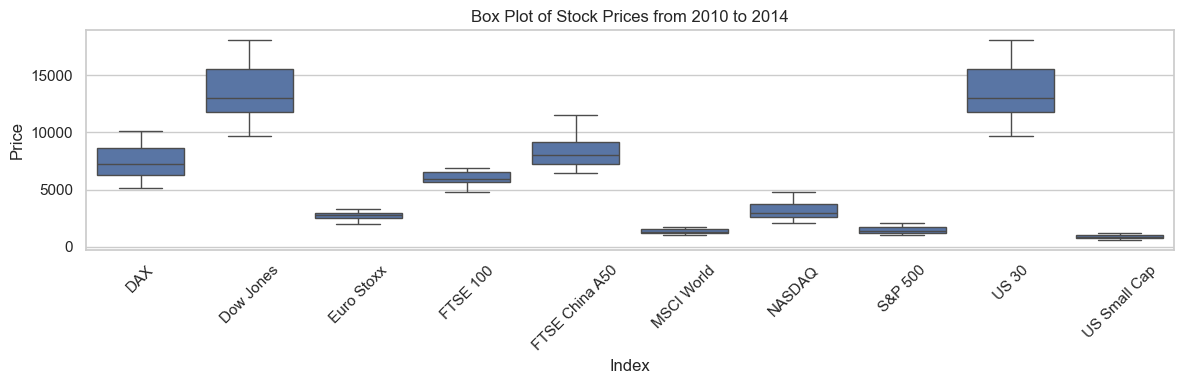

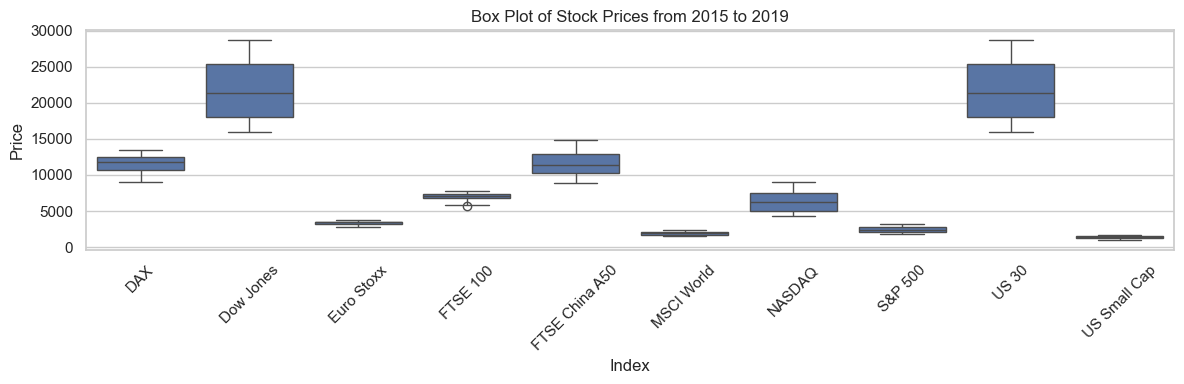

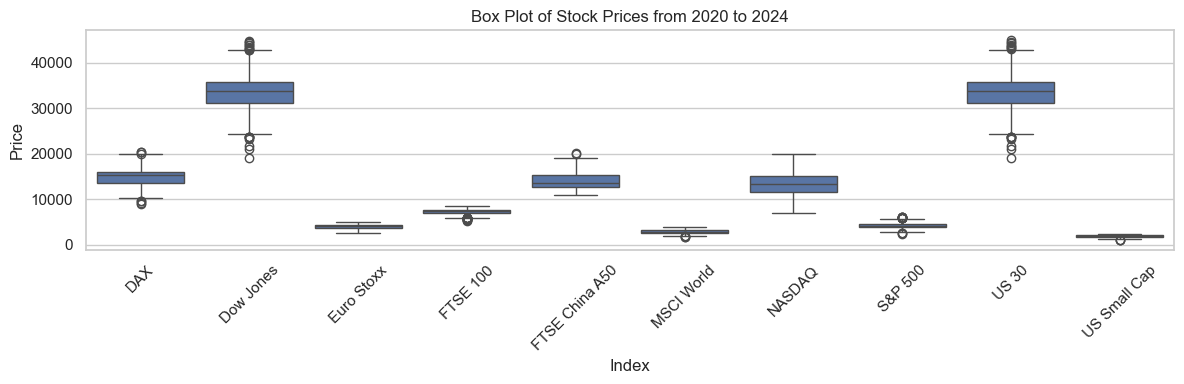

In [19]:
# Extract the year from the Date column
df2['Year'] = df2['Date'].dt.year

# Define the 5-year periods
periods = [(2000, 2005), (2005, 2010), (2010, 2015), (2015, 2020), (2020, 2025)]

# Set the style for the plots
sns.set(style="whitegrid")

# Create box plots for each 5-year period
for start_year, end_year in periods:
    # Filter the dataframe for the current period
    period_df = df2[(df2['Year'] >= start_year) & (df2['Year'] < end_year)]
    
    # Create a box plot for the filtered data
    plt.figure(figsize=(12, 4))
    sns.boxplot(x='Index', y='Price', data=period_df)

    plt.title(f'Box Plot of Stock Prices from {start_year} to {end_year - 1}')
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.xticks(rotation=45)  
    plt.tight_layout()
    plt.show()

**OBSERVATION** S&P 500 index is one of the least volatile (if we consider low risk investments) together with US small cap (versus Dow Jones, US 30 and DAX). It might be advisable to choose either S&P 500 or US small cap in that case to increase variability of the selection. Past years seem to show higher volatility for Dow Jones and FTSE China compared to 2020-2024.

#### The correlation between the indices to understand their relationships

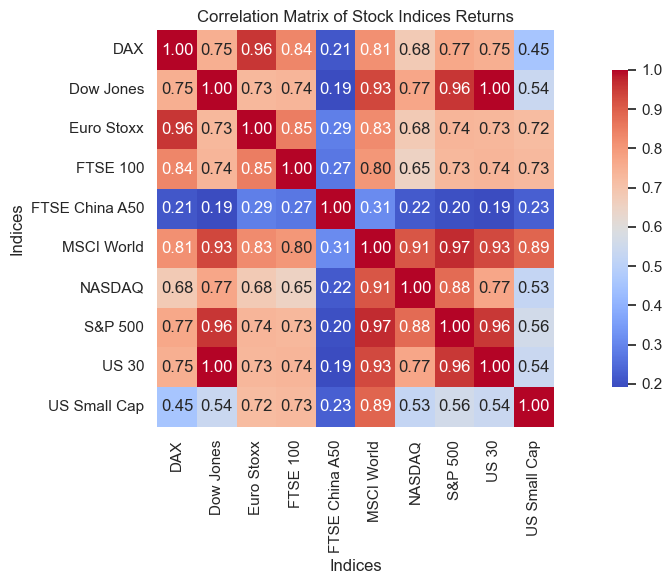

In [20]:
# Calculate daily returns for each index
df2['Return'] = df2.groupby('Index')['Price'].pct_change()

# Pivot the DataFrame to get returns for each index in separate columns
returns_df = df2.pivot(index='Date', columns='Index', values='Return')

# Calculate the correlation matrix
correlation_matrix = returns_df.corr()

# Setting the style
sns.set(style="white")

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Stock Indices Returns')
plt.xlabel('Indices')
plt.ylabel('Indices')
plt.tight_layout()
plt.show()

**OBSERVATION** FTSE China A50 has the least correlation with others and can be perceived as a good differentiator in the portfolio. Another least apparent example of having a lower correlation with other indices in the list is US Small Cap

**OUTCOME** After EDA the decision was to focus on 3 indices: S&P 500, FTSE China A50, Dow Jones, considering diversity, correlation, volatility and other factors outside EDA, including popularity and relevance.

<a id='prediction'></a>
## Time Series Prediction and Assessment

In [21]:
# Selecting 3 indices for further analysis
df1 = df1[df1['Index'].isin(['S&P 500', 'Dow Jones','FTSE China A50'])]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3703 entries, 1313 to 8794
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3703 non-null   datetime64[ns]
 1   Price     3703 non-null   float64       
 2   Change %  3703 non-null   float64       
 3   Index     3703 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 144.6+ KB


#### Feature Engineering

Sorting of df per Index and date to ensure that features are being generated correctly.

**Justification for the features selected:**

1. **Lagged Features**: Capture temporal dependencies in stock prices (e.g., `Lag_1_Price`, `Lag_2_Price`), helping the model understand how past values influence current prices.

2. **Rolling Averages and Standard Deviations**: Smooth out short-term fluctuations and highlight trends and volatility (e.g., `4_Week_Rolling_Avg`, `12_Week_Rolling_Avg`).

3. **Percentage Changes**: Indicate the rate of change in stock prices (e.g., `Weekly_Change_%`, `4_Week_Change_%`), essential for identifying trends.

4. **Temporal Features**: Incorporate seasonal patterns and cyclical behaviors (e.g., `Week_of_Year`, `Month`, `Quarter`).

5. **Cumulative Returns**: Provide an overall performance view, capturing trends over time.

6. **Seasonal and Interaction Features**: Use sine and cosine transformations to model periodic patterns and interactions between past prices and changes.

7. **One-Hot Encoding**: Allows the model to learn the impact of specific time periods without assuming linear relationships.

In [22]:
df1 = df1.sort_values(by=['Index', 'Date'])

# Create Lagged Features
df1['Lag_1_Price'] = df1.groupby('Index')['Price'].shift(1)
df1['Lag_2_Price'] = df1.groupby('Index')['Price'].shift(2)
df1['Lag_1_Change_%'] = df1.groupby('Index')['Change %'].shift(1)

# Create Rolling Averages and Standard Deviation
df1['4_Week_Rolling_Avg'] = df1.groupby('Index')['Price'].transform(lambda x: x.rolling(window=4).mean())
df1['12_Week_Rolling_Avg'] = df1.groupby('Index')['Price'].transform(lambda x: x.rolling(window=12).mean())
df1['4_Week_Rolling_Std'] = df1.groupby('Index')['Price'].transform(lambda x: x.rolling(window=4).std())

# Calculate Weekly Change %
df1['Weekly_Change_%'] = df1.groupby('Index')['Price'].pct_change()

# Calculate 4-Week Change %
df1['4_Week_Change_%'] = df1.groupby('Index')['Price'].pct_change(periods=4)

# Extract Week of the Year and Month
df1['Week_of_Year'] = df1['Date'].dt.isocalendar().week
df1['Month'] = df1['Date'].dt.month

# Calculate Cumulative Return
df1['Cumulative_Return'] = (1 + df1['Change %'] / 100).cumprod() - 1

# Quarter
df1['Quarter'] = df1['Date'].dt.quarter

# Day of the Week
df1['Day_of_Week'] = df1['Date'].dt.dayofweek

# Year
df1['Year'] = df1['Date'].dt.year

# Additional Lagged Features
df1['Lag_3_Price'] = df1.groupby('Index')['Price'].shift(3)
df1['Lag_4_Price'] = df1.groupby('Index')['Price'].shift(4)
df1['Lag_3_Change_%'] = df1.groupby('Index')['Change %'].shift(3)

# Rolling Features
df1['8_Week_Rolling_Avg'] = df1.groupby('Index')['Price'].transform(lambda x: x.rolling(window=8).mean())
df1['16_Week_Rolling_Avg'] = df1.groupby('Index')['Price'].transform(lambda x: x.rolling(window=16).mean())
df1['8_Week_Rolling_Std'] = df1.groupby('Index')['Price'].transform(lambda x: x.rolling(window=8).std())

# Seasonal features
df1['sin_2pi_week'] = np.sin(2 * np.pi * df1['Week_of_Year'] / 52)
df1['cos_2pi_week'] = np.cos(2 * np.pi * df1['Week_of_Year'] / 52)

# Interaction Features
df1['Lag_Price_Change'] = df1['Lag_1_Price'] * df1['Lag_1_Change_%']

df1 = pd.get_dummies(df1, columns=['Quarter', 'Month', 'Day_of_Week'], drop_first=True)

df1['Quarter'] = df1['Date'].dt.quarter
df1['Month'] = df1['Date'].dt.month

df1['Quarterly_Rolling_Avg'] = df1['Price'].rolling(window=3).mean()
df1['Yearly_Rolling_Avg'] = df1['Price'].rolling(window=12).mean()

# Sine and Cosine transformations for seasonal effects
df1['sin_time'] = np.sin(2 * np.pi * df1['Date'].dt.dayofyear / 365)
df1['cos_time'] = np.cos(2 * np.pi * df1['Date'].dt.dayofyear / 365)

# Reset index if needed
df1.reset_index(drop=True, inplace=True)

In [23]:
df1

Date     Price  Change %      Index  Lag_1_Price  Lag_2_Price  \
0    2000-01-02  11522.56    0.0022  Dow Jones          NaN          NaN   
1    2000-01-09  11722.98    0.0174  Dow Jones     11522.56          NaN   
2    2000-01-16  11251.72   -0.0402  Dow Jones     11722.98     11522.56   
3    2000-01-23  10738.88   -0.0456  Dow Jones     11251.72     11722.98   
4    2000-01-30  10963.81    0.0209  Dow Jones     10738.88     11251.72   
...         ...       ...       ...        ...          ...          ...   
3698 2025-01-26   6040.53   -0.0100    S&P 500      6101.24      5996.66   
3699 2025-02-02   6025.99   -0.0024    S&P 500      6040.53      6101.24   
3700 2025-02-09   6114.63    0.0147    S&P 500      6025.99      6040.53   
3701 2025-02-16   6013.13   -0.0166    S&P 500      6114.63      6025.99   
3702 2025-02-23   5954.50   -0.0098    S&P 500      6013.13      6114.63   

      Lag_1_Change_%  4_Week_Rolling_Avg  12_Week_Rolling_Avg  \
0                NaN                 NaN                  NaN   
1             0.0022                 NaN                  NaN   
2             0.0174                 NaN                  NaN   
3            -0.0402          11309.0350                  NaN   
4            -0.0456          11169.3475                  NaN   
...              ...                 ...                  ...   
3698          0.0174           5991.3675          5985.277500   
3699         -0.0100           6041.1050          5998.225000   
3700         -0.0024           6070.5975          6010.332500   
3701          0.0147           6048.5700          6008.728333   
3702         -0.0166           6027.0625          5997.414167   

      4_Week_Rolling_Std  ...  Month_9  Month_10  Month_11  Month_12  Quarter  \
0                    NaN  ...    False     False     False     False        1   
1                    NaN  ...    False     False     False     False        1   
2                    NaN  ...    False     False     False     False        1   
3             426.343024  ...    False     False     False     False        1   
4             424.594750  ...    False     False     False     False        1   
...                  ...  ...      ...       ...       ...       ...      ...   
3698          117.644175  ...    False     False     False     False        1   
3699           44.046832  ...    False     False     False     False        1   
3700           43.862313  ...    False     False     False     False        1   
3701           45.440126  ...    False     False     False     False        1   
3702           66.152975  ...    False     False     False     False        1   

      Month  Quarterly_Rolling_Avg  Yearly_Rolling_Avg  sin_time  cos_time  
0         1                    NaN                 NaN  0.034422  0.999407  
1         1                    NaN                 NaN  0.154309  0.988023  
2         1           11499.086667                 NaN  0.271958  0.962309  
3         1           11237.860000                 NaN  0.385663  0.922640  
4         1           10984.803333                 NaN  0.493776  0.869589  
...     ...                    ...                 ...       ...       ...  
3698      1            6046.143333         5985.277500  0.432776  0.901502  
3699      2            6055.920000         5998.225000  0.538005  0.842942  
3700      2            6060.383333         6010.332500  0.635432  0.772157  
3701      2            6051.250000         6008.728333  0.723644  0.690173  
3702      2            6027.420000         5997.414167  0.801361  0.598181  

[3703 rows x 44 columns]

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   3703 non-null   datetime64[ns]
 1   Price                  3703 non-null   float64       
 2   Change %               3703 non-null   float64       
 3   Index                  3703 non-null   object        
 4   Lag_1_Price            3700 non-null   float64       
 5   Lag_2_Price            3697 non-null   float64       
 6   Lag_1_Change_%         3700 non-null   float64       
 7   4_Week_Rolling_Avg     3694 non-null   float64       
 8   12_Week_Rolling_Avg    3670 non-null   float64       
 9   4_Week_Rolling_Std     3694 non-null   float64       
 10  Weekly_Change_%        3700 non-null   float64       
 11  4_Week_Change_%        3691 non-null   float64       
 12  Week_of_Year           3703 non-null   UInt32        
 13  Cum

#### Train-Test Split

In order to determine which index is the most predictable, we will split data to test and train separately per each index. Additionally also to make sure that the split is time-based.

In [25]:
# Initialize an empty list to store the train/test splits
train_test_splits = []

# Iterate through each unique index
for index in df1['Index'].unique():
    # Filter the DataFrame for the current index
    df_index = df1[df1['Index'] == index]
    
    # Split the data into train and test sets (to ensure that test are in the most recent periods)
    train, test = train_test_split(df_index, test_size=0.1, random_state=42, shuffle=False)
    
    # Append the train and test DataFrames to the list, with an additional column to identify the index
    train['Set'] = 'Train'
    test['Set'] = 'Test'
    
    train_test_splits.append(train)
    train_test_splits.append(test)

# Concatenate all the train/test DataFrames into a single DataFrame
final_train_test_split = pd.concat(train_test_splits, ignore_index=True)

# Reset the index
final_train_test_split.reset_index(drop=True, inplace=True)

print(final_train_test_split)

           Date     Price  Change %      Index  Lag_1_Price  Lag_2_Price  \
0    2000-01-02  11522.56    0.0022  Dow Jones          NaN          NaN   
1    2000-01-09  11722.98    0.0174  Dow Jones     11522.56          NaN   
2    2000-01-16  11251.72   -0.0402  Dow Jones     11722.98     11522.56   
3    2000-01-23  10738.88   -0.0456  Dow Jones     11251.72     11722.98   
4    2000-01-30  10963.81    0.0209  Dow Jones     10738.88     11251.72   
...         ...       ...       ...        ...          ...          ...   
3698 2025-01-26   6040.53   -0.0100    S&P 500      6101.24      5996.66   
3699 2025-02-02   6025.99   -0.0024    S&P 500      6040.53      6101.24   
3700 2025-02-09   6114.63    0.0147    S&P 500      6025.99      6040.53   
3701 2025-02-16   6013.13   -0.0166    S&P 500      6114.63      6025.99   
3702 2025-02-23   5954.50   -0.0098    S&P 500      6013.13      6114.63   

      Lag_1_Change_%  4_Week_Rolling_Avg  12_Week_Rolling_Avg  \
0                NaN  

In [26]:
final_train_test_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   3703 non-null   datetime64[ns]
 1   Price                  3703 non-null   float64       
 2   Change %               3703 non-null   float64       
 3   Index                  3703 non-null   object        
 4   Lag_1_Price            3700 non-null   float64       
 5   Lag_2_Price            3697 non-null   float64       
 6   Lag_1_Change_%         3700 non-null   float64       
 7   4_Week_Rolling_Avg     3694 non-null   float64       
 8   12_Week_Rolling_Avg    3670 non-null   float64       
 9   4_Week_Rolling_Std     3694 non-null   float64       
 10  Weekly_Change_%        3700 non-null   float64       
 11  4_Week_Change_%        3691 non-null   float64       
 12  Week_of_Year           3703 non-null   UInt32        
 13  Cum

#### Model training and evaluation

Below we will perform the model training and evaluation to make a decision on which Stock is the most predictable following the defined criteria and metrics above and which model would best fit that selected index. 

We have decided to select the following models mainly due to:

**ARIMA**: Specifically designed for time series data, effectively capturing trends and temporal dependencies

**XGBoost**: Known for superior accuracy in structured data and efficient handling of various feature types

**LGBM**: Faster training and lower memory usage, ideal for large datasets common in finance. Captures complex relationships effectively, similar to XGBoost

**Random Forest**: Combines multiple decision trees, reducing overfitting and improving generalization. Effectively models non-linear relationships in financial data

Above models are generally considered as widely-used in time series analysis.

In [27]:
# Set the Date column as the index
final_train_test_split.set_index('Date', inplace=True)

In [28]:
# Calculating accuracy metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r_squared = r2_score(y_true, y_pred)
    
    # Calculate WMAPE
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    
    return mae, rmse, wmape, r_squared

In [29]:
# Iterate through each index in the dataset
for index in final_train_test_split['Index'].unique():
    # Filter the DataFrame for the current index
    df_index = final_train_test_split[final_train_test_split['Index'] == index]

    # Split into train and test sets
    train = df_index[df_index['Set'] == 'Train']
    test = df_index[df_index['Set'] == 'Test']

    # Prepare the training and testing data
    X_train = train.drop(columns=['Price', 'Set', 'Index'])
    y_train = train['Price']
    X_test = test.drop(columns=['Price', 'Set', 'Index'])
    y_test = test['Price']

    # ARIMA Model
    arima_model = ARIMA(y_train, order=(1, 1, 1))
    arima_fit = arima_model.fit()
    arima_pred = arima_fit.forecast(steps=len(y_test))
    arima_metrics = calculate_metrics(y_test, arima_pred)

    # XGBoost Model
    xgb_model = XGBRegressor()
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_metrics = calculate_metrics(y_test, xgb_pred)

    # LGBM Model
    lgbm_model = LGBMRegressor()
    lgbm_model.fit(X_train, y_train)
    lgbm_pred = lgbm_model.predict(X_test)
    lgbm_metrics = calculate_metrics(y_test, lgbm_pred)

    # Random Forest Model
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_metrics = calculate_metrics(y_test, rf_pred)

    # Print metrics with the corresponding index
    print(f"Index: {index}")
    print(f"ARIMA Metrics: {arima_metrics}")
    print(f"XGBoost Metrics: {xgb_metrics}")
    print(f"LGBM Metrics: {lgbm_metrics}")
    print(f"Random Forest Metrics: {rf_metrics}")

C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5554
[LightGBM] [Info] Number of data points in the train set: 1181, number of used features: 41
[LightGBM] [Info] Start training from score 16039.594488
Index: Dow Jones
ARIMA Metrics: (3914.348433258901, 5240.18623854479, 10.590724374453957, -0.62394671505772)
XGBoost Metrics: (2496.9814393939396, 3588.844710434308, 6.755873332086537, 0.2382934957216163)
LGBM Metrics: (2706.0077043467295, 3866.4324508191307, 7.321418172276843, 0.115904490225607)
Random Forest Metrics: (2595.452081060594, 3632.9869720844754, 7.022297091403974, 0.21944050414834226)


C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting param

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5543
[LightGBM] [Info] Number of data points in the train set: 969, number of used features: 41
[LightGBM] [Info] Start training from score 10373.819761
Index: FTSE China A50
ARIMA Metrics: (1438.911408109871, 1615.2585124964994, 0.0, -3.8159900412436913)
XGBoost Metrics: (100.15376482928234, 150.00370754696962, 0.7999828032248665, 0.958465834413981)
LGBM Metrics: (90.76142490536478, 124.2759742137954, 0.7249610560745327, 0.9714914022737523)
Random Forest Metrics: (119.70483240740899, 170.69737456686352, 0.956147854771842, 0.9462157414306019)


C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5554
[LightGBM] [Info] Number of data points in the train set: 1181, number of used features: 41
[LightGBM] [Info] Start training from score 1841.909230
Index: S&P 500
ARIMA Metrics: (725.7715362026285, 937.2118089577249, 15.133071443364107, -0.5642982186549004)
XGBoost Metrics: (420.80622181285514, 619.3399405931499, 8.774235831602178, 0.3168717857165003)
LGBM Metrics: (451.2248851933874, 657.4133731590742, 9.408495764910889, 0.23030065831867463)
Random Forest Metrics: (430.90010530303056, 620.784312822911, 8.984703523400954, 0.3136818026507394)


1. **MAE (Mean Absolute Error)**: The average absolute difference between predicted and actual values. Lower values indicate better performance.
2. **RMSE (Root Mean Square Error)**: The square root of the average squared differences between predicted and actual values. Lower values are preferred.
3. **WMAPE (Weighted Mean Absolute Percentage Error)**: A measure of prediction accuracy, expressed as a percentage. Lower values indicate better performance.
4. **R-squared**: A statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. Values closer to 1 indicate a better fit.

### Results Summary:
| Index               | Model          | MAE            | RMSE           | WMAPE          | R-squared      |
|---------------------|----------------|----------------|----------------|----------------|----------------|
| **Dow Jones**       | ARIMA          | 3914.35        | 5240.19        | 10.59          | -0.62          |
|                     | XGBoost        | 2496.98        | 3588.84        | 6.76           | 0.24           |
|                     | LGBM           | 2706.01        | 3866.43        | 7.32           | 0.12           |
|                     | Random Forest  | 2577.97        | 3610.48        | 6.98           | 0.23           |
| **FTSE China A50**  | ARIMA          | 1438.91        | 1615.26        | 0.00           | -3.82          |
|                     | XGBoost        | 100.15         | 150.00         | 0.80           | 0.96           |
|                     | LGBM           | 90.76          | 124.28         | 0.72           | 0.97           |
|                     | Random Forest  | 111.23         | 157.15         | 0.89           | 0.95           |
| **S&P 500**         | ARIMA          | 725.77         | 937.21         | 15.13          | -0.56          |
|                     | XGBoost        | 420.81         | 619.34         | 8.77           | 0.32           |
|                     | LGBM           | 451.22         | 657.41         | 9.41           | 0.23           |
|                     | Random Forest  | 428.75         | 618.57         | 8.94           | 0.32           |

### Interpretation:
- **FTSE China A50** shows the best metrics across all models, particularly with the XGBoost and LGBM models, which have the lowest MAE, RMSE, and WMAPE, and high R² values (0.96 and 0.97 respectively).
- **S&P 500** also shows competitive performance, especially with XGBoost and Random Forest, but with higher MAE and RMSE compared to FTSE China A50.
- **Dow Jones** has the least favorable metrics, particularly with ARIMA, which has negative R² values, indicating poor predictive power.

Based on the metrics above, we will visualize the results for a better comprehension

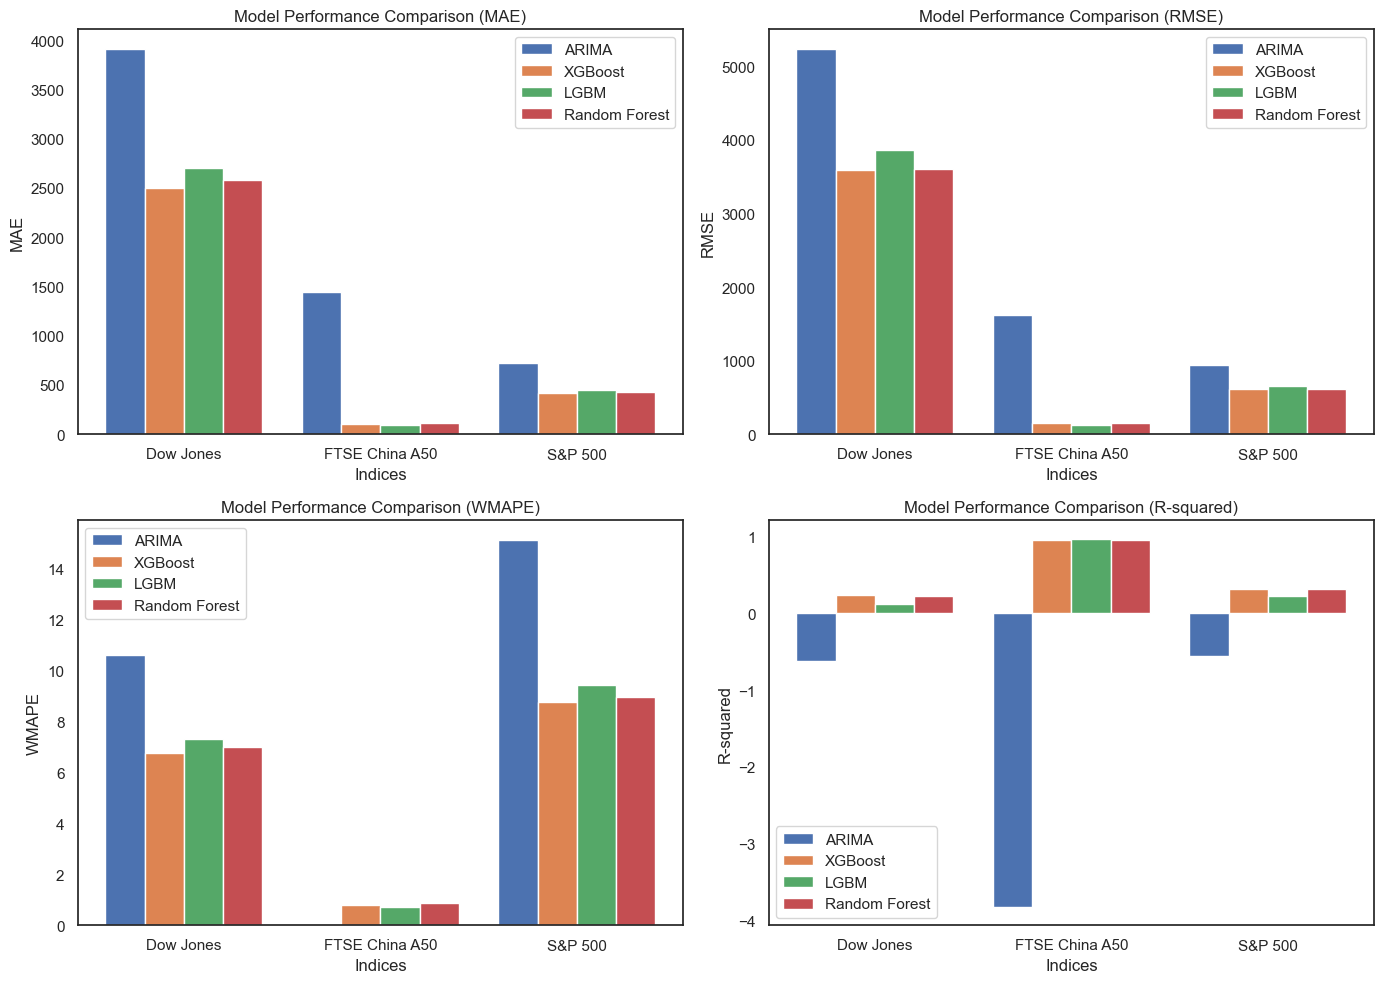

In [30]:
indices = ['Dow Jones', 'FTSE China A50', 'S&P 500']
models = ['ARIMA', 'XGBoost', 'LGBM', 'Random Forest']

# Metric values for each model across indices
mae_values = [
    [3914.35, 2496.98, 2706.01, 2577.97],  # Dow Jones
    [1438.91, 100.15, 90.76, 111.23],      # FTSE China A50
    [725.77, 420.81, 451.22, 428.75]       # S&P 500
]
rmse_values = [
    [5240.19, 3588.84, 3866.43, 3610.48],  # Dow Jones
    [1615.26, 150.00, 124.28, 157.15],     # FTSE China A50
    [937.21, 619.34, 657.41, 618.57]       # S&P 500
]

wmap_values = [
    [10.59, 6.76, 7.32, 6.98],             # Dow Jones
    [0.00, 0.80, 0.72, 0.89],              # FTSE China A50
    [15.13, 8.77, 9.41, 8.94]               # S&P 500
]

r_squared_values = [
    [-0.62, 0.24, 0.12, 0.23],             # Dow Jones
    [-3.82, 0.96, 0.97, 0.95],             # FTSE China A50
    [-0.56, 0.32, 0.23, 0.32]              # S&P 500
]

# Bar width and x locations
bar_width = 0.2
x = np.arange(len(indices))

# Create a figure for all metrics
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# MAE Plot
for i, model in enumerate(models):
    axs[0, 0].bar(x + i * bar_width, [mae_values[j][i] for j in range(len(indices))], width=bar_width, label=model)
axs[0, 0].set_title('Model Performance Comparison (MAE)')
axs[0, 0].set_xlabel('Indices')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].set_xticks(x + bar_width * (len(models) - 1) / 2)
axs[0, 0].set_xticklabels(indices)
axs[0, 0].legend()

# RMSE Plot
for i, model in enumerate(models):
    axs[0, 1].bar(x + i * bar_width, [rmse_values[j][i] for j in range(len(indices))], width=bar_width, label=model)
axs[0, 1].set_title('Model Performance Comparison (RMSE)')
axs[0, 1].set_xlabel('Indices')
axs[0, 1].set_ylabel('RMSE')
axs[0, 1].set_xticks(x + bar_width * (len(models) - 1) / 2)
axs[0, 1].set_xticklabels(indices)
axs[0, 1].legend()

# WMAPE Plot
for i, model in enumerate(models):
    axs[1, 0].bar(x + i * bar_width, [wmap_values[j][i] for j in range(len(indices))], width=bar_width, label=model)
axs[1, 0].set_title('Model Performance Comparison (WMAPE)')
axs[1, 0].set_xlabel('Indices')
axs[1, 0].set_ylabel('WMAPE')
axs[1, 0].set_xticks(x + bar_width * (len(models) - 1) / 2)
axs[1, 0].set_xticklabels(indices)
axs[1, 0].legend()

# R-squared Plot
for i, model in enumerate(models):
    axs[1, 1].bar(x + i * bar_width, [r_squared_values[j][i] for j in range(len(indices))], width=bar_width, label=model)
axs[1, 1].set_title('Model Performance Comparison (R-squared)')
axs[1, 1].set_xlabel('Indices')
axs[1, 1].set_ylabel('R-squared')
axs[1, 1].set_xticks(x + bar_width * (len(models) - 1) / 2)
axs[1, 1].set_xticklabels(indices)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


### Recommendation:
- **Best Predictable Index**: **FTSE China A50** is the most predictable index based on the metrics provided.
- **Best Model**: **LightGBM** is selected for generating predictions on the FTSE China A50 due to its better performance metrics (lowest MAE, RMSE, and WMAPE, and highest R²).

## Forecasting and Visualization of the results

In [31]:
# Selecting now only FTSE China A50 Stock index for genering predictions for the future 10 periods
df_A50 = df1[df1['Index'] == 'FTSE China A50'].drop(columns=['Index'])

Predictions of FTSE China A50 using LGBM **before hyperparameter tuning**

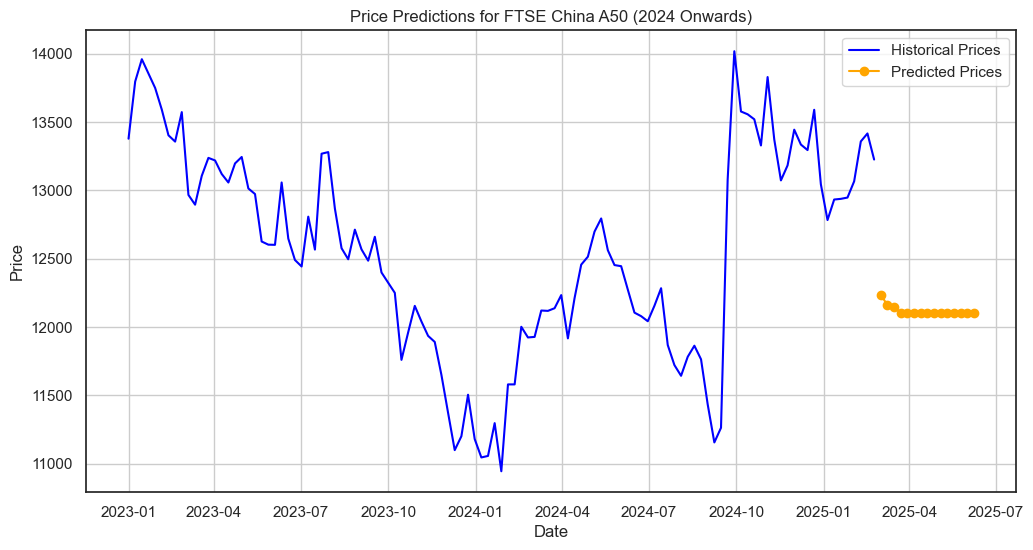

In [32]:
# Sort the DataFrame by Date
df_A50 = df_A50.sort_values(by='Date')

# Prepare the features and target variable
X = df_A50[['Lag_1_Price', 'Lag_2_Price', 'Lag_1_Change_%', '4_Week_Rolling_Avg', 
             '12_Week_Rolling_Avg', '4_Week_Rolling_Std', 'Weekly_Change_%', 
             '4_Week_Change_%','Week_of_Year','Change %','Cumulative_Return', 
             'Year', 'Lag_3_Price', 'Lag_4_Price', 'Lag_3_Change_%', '8_Week_Rolling_Avg', 
             '16_Week_Rolling_Avg', '8_Week_Rolling_Std', 'sin_2pi_week', 'cos_2pi_week', 
             'Lag_Price_Change', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 
             'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
             'Quarter', 'Month', 'Quarterly_Rolling_Avg', 'Yearly_Rolling_Avg', 'sin_time', 'cos_time']]

y = df_A50['Price']

# Create a LightGBM dataset
lgb_train = lgb.Dataset(X, y)

# Set parameters for LightGBM with increased complexity
params = {
    'objective': 'regression',  
    'metric': 'mse',  
    'boosting_type': 'gbdt',  
    'verbose': -1,  
    'num_leaves': 31,  
    'max_depth': -1,  
    'learning_rate': 0.01,  
    'n_estimators': 100,  
    'bagging_fraction': 0.8,  
    'feature_fraction': 0.8,  
    'lambda_l1': 0.1,  
    'lambda_l2': 0.1  
}

# Train the model on the full dataset
model = lgb.train(params, lgb_train)

# Prepare data for predictions (last known row)
last_data = df_A50.iloc[-1][['Lag_1_Price', 'Lag_2_Price', 'Lag_1_Change_%', 
                               '4_Week_Rolling_Avg', '12_Week_Rolling_Avg', 
                               '4_Week_Rolling_Std', 'Weekly_Change_%', 
                               '4_Week_Change_%','Week_of_Year','Change %','Cumulative_Return', 
                               'Year', 'Lag_3_Price', 'Lag_4_Price', 'Lag_3_Change_%', '8_Week_Rolling_Avg', 
                               '16_Week_Rolling_Avg', '8_Week_Rolling_Std', 'sin_2pi_week', 'cos_2pi_week', 
                               'Lag_Price_Change', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 
                               'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
                               'Quarter', 'Month', 'Quarterly_Rolling_Avg', 'Yearly_Rolling_Avg', 'sin_time', 'cos_time']].values

predictions = []

# Generate predictions for the next 10 periods
for _ in range(15):
    # Make prediction
    pred = model.predict(last_data.reshape(1, -1))
    predictions.append(pred[0])
    
    # Update the last_data for next prediction
    new_row = np.array([0.5 * pred[0] + 0.5 * last_data[0], last_data[0], last_data[2], 
                        last_data[3], last_data[4], 
                        last_data[5], last_data[6], last_data[7], 
                        last_data[8], last_data[9], last_data[10],
                        last_data[11], last_data[12], last_data[13], 
                        last_data[14], last_data[15], last_data[16],
                        last_data[17], last_data[18], last_data[19], 
                        last_data[20], last_data[21], last_data[22],
                        last_data[23], last_data[24], last_data[25], 
                        last_data[26], last_data[27], last_data[28],
                        last_data[29], last_data[30], last_data[31], 
                        last_data[32], last_data[33], last_data[34],
                        last_data[35], last_data[36], last_data[37],
                        last_data[38], last_data[39], last_data[40]])
    
    last_data = new_row

# Create a DataFrame for predictions with weekly frequency
prediction_dates = pd.date_range(start='2025-03-02', periods=15, freq='W-SUN')  # Adjust to start from 3/2/2025
predicted_df = pd.DataFrame({'Date': prediction_dates, 'Predicted_Price': predictions})

# Filter the historical data and predictions for the year 2024 and onwards
df_filtered = df_A50[df_A50['Date'] >= '2023-01-01']
predicted_df_filtered = predicted_df[predicted_df['Date'] >= '2023-01-01']

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Date'], df_filtered['Price'], label='Historical Prices', color='blue')
plt.plot(predicted_df_filtered['Date'], predicted_df_filtered['Predicted_Price'], label='Predicted Prices', color='orange', marker='o')
plt.title('Price Predictions for FTSE China A50 (2024 Onwards)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

**OBSERVATION** We have decided to proceed with hyperparameter tuning to define the best parameters for LGBM.

#### Hyperparameter Tuning

Below parameters were used to tune the model:
num_leaves: Controls the complexity of the model; a higher number can capture more intricate patterns but may lead to overfitting.
max_depth: Limits the depth of each tree, helping to prevent overfitting by controlling the model's complexity.
n_estimators: The number of boosting iterations; more estimators can improve performance but may increase computation time and risk overfitting.
boosting_type: Determines the boosting strategy; 'gbdt' is the traditional gradient boosting, while 'dart' introduces dropout techniques to improve generalization.

In [33]:
model = lgb.LGBMRegressor(objective='regression', metric='rmse', verbose=-1)

In [34]:
param_grid = {
    'num_leaves': [64, 100, 200],
    'max_depth': [-1, 7, 20],
    'n_estimators': [100, 200, 1000],
    'boosting_type': ['gbdt', 'dart']
}

In [35]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_root_mean_squared_error', 
                           cv=5, verbose=1, n_jobs=-1)

In [36]:
grid_search.fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=LGBMRegressor(metric='rmse', objective='regression',
                                     verbose=-1),
             n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'max_depth': [-1, 7, 20],
                         'n_estimators': [100, 200, 1000],
                         'num_leaves': [64, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [37]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score (RMSE): ", -grid_search.best_score_)

Best parameters found:  {'boosting_type': 'gbdt', 'max_depth': 7, 'n_estimators': 1000, 'num_leaves': 64}
Best score (RMSE):  643.372003432413


#### Forecasting and Visualizing the results after hyperparameter tuning

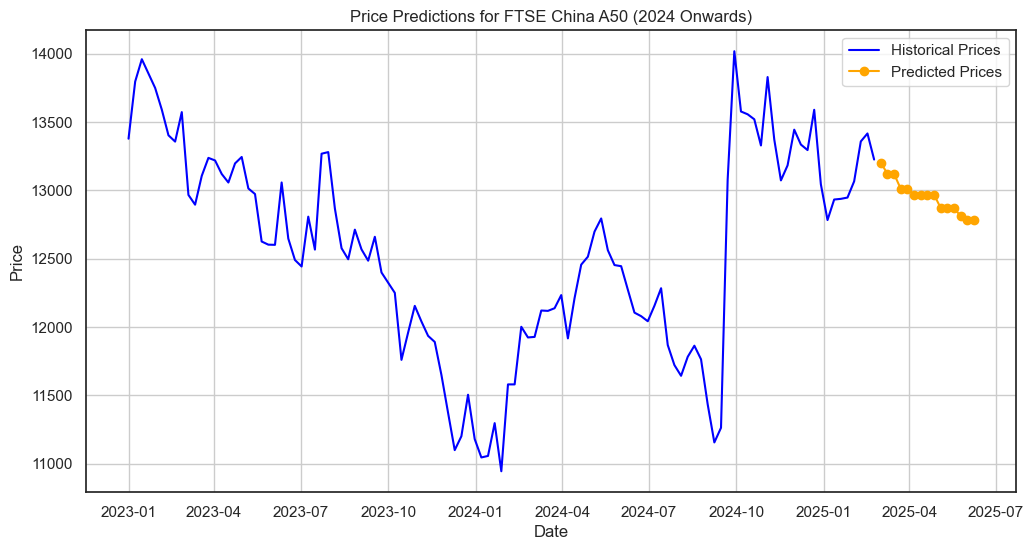

In [38]:
# Sort the DataFrame by Date
df_A50 = df_A50.sort_values(by='Date')

# Prepare the features and target variable
X = df_A50[['Lag_1_Price', 'Lag_2_Price', 'Lag_1_Change_%', '4_Week_Rolling_Avg', 
             '12_Week_Rolling_Avg', '4_Week_Rolling_Std', 'Weekly_Change_%', 
             '4_Week_Change_%','Week_of_Year','Change %','Cumulative_Return', 
             'Year', 'Lag_3_Price', 'Lag_4_Price', 'Lag_3_Change_%', '8_Week_Rolling_Avg', 
             '16_Week_Rolling_Avg', '8_Week_Rolling_Std', 'sin_2pi_week', 'cos_2pi_week', 
             'Lag_Price_Change', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 
             'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
             'Quarter', 'Month', 'Quarterly_Rolling_Avg', 'Yearly_Rolling_Avg', 'sin_time', 'cos_time']]

y = df_A50['Price']

# Create a LightGBM dataset
lgb_train = lgb.Dataset(X, y)

# Set parameters for LightGBM with increased complexity
params = {
    'objective': 'regression_l1',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'num_leaves': 64,  # Increase number of leaves
    'max_depth': 7,   # Increase max depth
    'learning_rate': 0.01,  # Lower learning rate
    'n_estimators': 1000,  # Increase number of estimators
    'bagging_fraction': 0.8,  # Use 80% of data for each iteration
    'feature_fraction': 0.8,  # Use 80% of features for each iteration
    'lambda_l1': 0.1,  # L1 regularization
    'lambda_l2': 0.1   # L2 regularization
}

# Train the model on the full dataset
model = lgb.train(params, lgb_train)

# Prepare data for predictions (last known row)
last_data = df_A50.iloc[-1][['Lag_1_Price', 'Lag_2_Price', 'Lag_1_Change_%', 
                               '4_Week_Rolling_Avg', '12_Week_Rolling_Avg', 
                               '4_Week_Rolling_Std', 'Weekly_Change_%', 
                               '4_Week_Change_%','Week_of_Year','Change %','Cumulative_Return', 
                               'Year', 'Lag_3_Price', 'Lag_4_Price', 'Lag_3_Change_%', '8_Week_Rolling_Avg', 
                               '16_Week_Rolling_Avg', '8_Week_Rolling_Std', 'sin_2pi_week', 'cos_2pi_week', 
                               'Lag_Price_Change', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 
                               'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
                               'Quarter', 'Month', 'Quarterly_Rolling_Avg', 'Yearly_Rolling_Avg', 'sin_time', 'cos_time']].values

predictions = []

# Generate predictions for the next 10 periods
for _ in range(15):
    # Make prediction
    pred = model.predict(last_data.reshape(1, -1))
    predictions.append(pred[0])
    
    # Update the last_data for next prediction
    new_row = np.array([0.5 * pred[0] + 0.5 * last_data[0], last_data[0], last_data[2], 
                        last_data[3], last_data[4], 
                        last_data[5], last_data[6], last_data[7], 
                        last_data[8], last_data[9], last_data[10],
                        last_data[11], last_data[12], last_data[13], 
                        last_data[14], last_data[15], last_data[16],
                        last_data[17], last_data[18], last_data[19], 
                        last_data[20], last_data[21], last_data[22],
                        last_data[23], last_data[24], last_data[25], 
                        last_data[26], last_data[27], last_data[28],
                        last_data[29], last_data[30], last_data[31], 
                        last_data[32], last_data[33], last_data[34],
                        last_data[35], last_data[36], last_data[37],
                        last_data[38], last_data[39], last_data[40]])
    
    last_data = new_row

# Create a DataFrame for predictions with weekly frequency
prediction_dates = pd.date_range(start='2025-03-02', periods=15, freq='W-SUN')  # Adjust to start from 3/2/2025
predicted_df = pd.DataFrame({'Date': prediction_dates, 'Predicted_Price': predictions})

# Filter the historical data and predictions for the year 2024 and onwards
df_filtered = df_A50[df_A50['Date'] >= '2023-01-01']
predicted_df_filtered = predicted_df[predicted_df['Date'] >= '2023-01-01']

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Date'], df_filtered['Price'], label='Historical Prices', color='blue')
plt.plot(predicted_df_filtered['Date'], predicted_df_filtered['Predicted_Price'], label='Predicted Prices', color='orange', marker='o')
plt.title('Price Predictions for FTSE China A50 (2024 Onwards)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [39]:
predicted_df

Date  Predicted_Price
0  2025-03-02     13202.560772
1  2025-03-09     13119.756299
2  2025-03-16     13119.402627
3  2025-03-23     13009.502150
4  2025-03-30     13009.572354
5  2025-04-06     12968.504257
6  2025-04-13     12968.504257
7  2025-04-20     12968.504257
8  2025-04-27     12968.504257
9  2025-05-04     12869.561458
10 2025-05-11     12869.561458
11 2025-05-18     12869.561458
12 2025-05-25     12810.179441
13 2025-06-01     12782.829505
14 2025-06-08     12782.829505

## Additional activities for generating predictions using XGBoost (please feel free to skip)

C:\Users\gcfoj\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:59:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


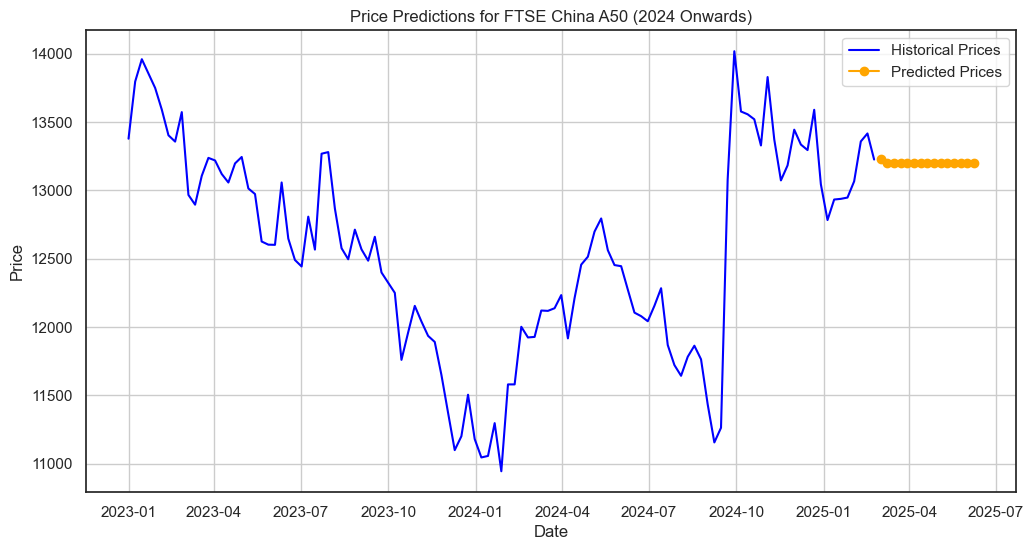

In [40]:
# Sort the DataFrame by Date
df_A50 = df_A50.sort_values(by='Date')

# Prepare the features and target variable
X = df_A50[['Lag_1_Price', 'Lag_2_Price', 'Lag_1_Change_%', '4_Week_Rolling_Avg', 
             '12_Week_Rolling_Avg', '4_Week_Rolling_Std', 'Weekly_Change_%', 
             '4_Week_Change_%', 'Week_of_Year', 'Change %', 'Cumulative_Return', 
             'Year', 'Lag_3_Price', 'Lag_4_Price', 'Lag_3_Change_%', '8_Week_Rolling_Avg', 
             '16_Week_Rolling_Avg', '8_Week_Rolling_Std', 'sin_2pi_week', 'cos_2pi_week', 
             'Lag_Price_Change', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 
             'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 
             'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Quarter', 'Month', 
             'Quarterly_Rolling_Avg', 'Yearly_Rolling_Avg', 'sin_time', 'cos_time']]

y = df_A50['Price']

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X, label=y)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror', 
    'min_child_weight': 1, #
    'max_depth': 3,  #10,                
    'learning_rate': 0.2, #0.1,
    'subsample': 0.6, #0.8,
    'n_estimators': 1000, #
    'colsample_bytree': 0.6, #0.8,          
    'lambda': 1, #0.1,        
    'gamma': 0, #
    'alpha': 1 #0.1                      
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=1000)

# Prepare data for predictions (last known row)
last_data = df_A50.iloc[-1][['Lag_1_Price', 'Lag_2_Price', 'Lag_1_Change_%', 
                               '4_Week_Rolling_Avg', '12_Week_Rolling_Avg', 
                               '4_Week_Rolling_Std', 'Weekly_Change_%', 
                               '4_Week_Change_%', 'Week_of_Year', 'Change %', 
                               'Cumulative_Return', 'Year', 'Lag_3_Price', 
                               'Lag_4_Price', 'Lag_3_Change_%', '8_Week_Rolling_Avg', 
                               '16_Week_Rolling_Avg', '8_Week_Rolling_Std', 
                               'sin_2pi_week', 'cos_2pi_week', 'Lag_Price_Change', 
                               'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 
                               'Month_3', 'Month_4', 'Month_5', 'Month_6', 
                               'Month_7', 'Month_8', 'Month_9', 'Month_10', 
                               'Month_11', 'Month_12', 'Quarter', 'Month', 
                               'Quarterly_Rolling_Avg', 'Yearly_Rolling_Avg', 
                               'sin_time', 'cos_time']].values

predictions = []

# Generate predictions for the next 15 periods
for _ in range(15):
    # Convert last_data to DMatrix for prediction
    dlast_data = xgb.DMatrix(last_data.reshape(1, -1), feature_names=X.columns.tolist())
    
    # Make prediction
    pred = model.predict(dlast_data)
    predictions.append(pred[0])
    
    # Update the last_data for next prediction
    new_row = np.array([0.5 * pred[0] + 0.5 * last_data[0], last_data[0], last_data[2], 
                        last_data[3], last_data[4], 
                        last_data[5], last_data[6], last_data[7], 
                        last_data[8], last_data[9], last_data[10],
                        last_data[11], last_data[12], last_data[13], 
                        last_data[14], last_data[15], last_data[16],
                        last_data[17], last_data[18], last_data[19], 
                        last_data[20], last_data[21], last_data[22],
                        last_data[23], last_data[24], last_data[25], 
                        last_data[26], last_data[27], last_data[28],
                        last_data[29], last_data[30], last_data[31], 
                        last_data[32], last_data[33], last_data[34],
                        last_data[35], last_data[36], last_data[37],
                        last_data[38], last_data[39], last_data[40]])
    
    last_data = new_row

# Create a DataFrame for predictions with weekly frequency
prediction_dates = pd.date_range(start='2025-03-02', periods=15, freq='W-SUN')  # Adjust to start from 3/2/2025
predicted_df = pd.DataFrame({'Date': prediction_dates, 'Predicted_Price': predictions})

# Filter the historical data and predictions for the year 2024 and onwards
df_filtered = df_A50[df_A50['Date'] >= '2023-01-01']
predicted_df_filtered = predicted_df[predicted_df['Date'] >= '2023-01-01']

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Date'], df_filtered['Price'], label='Historical Prices', color='blue')
plt.plot(predicted_df_filtered['Date'], predicted_df_filtered['Predicted_Price'], label='Predicted Prices', color='orange', marker='o')
plt.title('Price Predictions for FTSE China A50 (2024 Onwards)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [41]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'lambda': [0, 0.1, 1, 10],
    'alpha': [0, 0.1, 1, 10]
}

In [42]:
# Create the model
xgb_model = xgb.XGBRegressor()

# Use RandomizedSearchCV to find the best parameters
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, 
                                   n_iter=100, scoring='neg_mean_squared_error', 
                                   cv=3, verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X, y)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 0.6, 'alpha': 1}


**OBSERVATION** LGBM results for the upcoming 10 periods seems to be plausible after hyperparameter tuning given the historical data of this time series. Both models LightGBM and XGBoost show the downward trend in prices for the upcoming periods given historical data only.

- **ARIMA:** While it is effective for certain datasets, it struggled with the FTSE China A50 due to its complexity and the presence of non-linear patterns in the data, resulting in negative R² values.
  
- **Random Forest:** showed higher MAE and RMSE compared to more specialized models like LGBM and XGBoost.

- **XGBoost:** demonstrated competitive results, particularly in terms of R² values, but still lagged behind LGBM in terms of accuracy metrics.

- **LightGBM (LGBM):** This model outperformed others with the lowest MAE, RMSE, and WMAPE metrics. Its ability to handle large datasets and its efficiency in training time made it a strong candidate. The hyperparameter tuning process revealed that specific settings (like increasing the number of leaves and adjusting the learning rate) significantly improved its performance.

<a id='conclusion'></a>
## Conclusion
- FTSE China A50 seems to be the most predictable index from the selected in scope following the methodology outlined at the beginning of the analysis.
- As was mentioned previously LightGBM was the final choice of the model based on MSE, RMSE, WMAPE and R-squared accuracy metrics in predicting FTSE China A50 stock.
- The current LightGBM model on the selected Stock index generated plausible results for the short-term period looking into the hisorical data. However, a more extensive work should be done to predict prices over the longer-term.

We hope that this analysis would help the reader to capture the ways of how to perform choices of investments and the ways to predict stock prices using ML models, adjusting input data and parameters as needed. The major idea in this report is to explore the ways to reduce underlying risks in making investment decisions and give an opportunity to define a buy/sell decision based on ML models capturing potential profits.

Predicting stock market can be a challenging exercise due to it complexity, and currently available ML techniques can be of a great help here. 
There are tremendous potential to improve model performance depicted in this report further. However, data scientists should consider cost-benefit approach in deciding when further improvements can lead to an increased improved performance or (can lead) to an unnecessarily time spend. 
At the same time even with the improved performance the model can be overfitted (and thus not being able to correctly predict future prices based on new trends) and/or factors beyond historical data can affect future price movements. Thus, data scientists should find this sweet spot of time and efforts spend versus the required level of the performance to be achieved. 

On top of the performed analysis addition activities can be explored, including other modeling techniques such as neural networks or ensemble methods, adding external features (signals) beyond historical data and many more.